In [1]:
# default_exp standard_themes/css

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics Multilabel Classification - Standard CSS Themes

> Models to predict what standard themes a verbatim belongs too

In [3]:
#export
import datetime
import sklearn.metrics as skm
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
#hide
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
#hide
print(f'fastai version: {fa2_version}')

fastai version: 2.0.14


In [6]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

Basic Configuration

In [7]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb')); len(vocab)

32408

In [8]:
bsz = 80
bptt= 72
wd = 1e-7

In [9]:
chunksize = 24000

include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

In [10]:
# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

Prepare the data source

In [11]:
train_df = pd.read_csv(STANDARD_THEME_CSS_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_CSS_PATH/'test.csv')

Remove any rows whre the "corpus_cols" are nan

In [12]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [13]:
STANDARD_THEME_CSS_LABELS

['accessible_to_customers',
 'consistency_in_policies_information',
 'cost_fees',
 'courteous_professional_staff',
 'effective_communications',
 'effectively_uses_websites_online_documentation',
 'helpful_staff',
 'knowledgeable_staff',
 'moving_in_a_positive_direction',
 'overall_satisfaction',
 'process_improvement',
 'provides_effective_advice_guidance',
 'provides_training_on_processes_applications',
 'resolves_problems_effectively',
 'responds_to_requests_within_an_acceptable_time',
 'understands_my_needs_and_requirements']

In [14]:
# 11/15/2018 - currently have to put all labels into a single column
# train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[STANDARD_THEME_CSS_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[STANDARD_THEME_CSS_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + STANDARD_THEME_CSS_LABELS].head()

,labels,accessible_to_customers,consistency_in_policies_information,cost_fees,courteous_professional_staff,effective_communications,effectively_uses_websites_online_documentation,helpful_staff,knowledgeable_staff,moving_in_a_positive_direction,overall_satisfaction,process_improvement,provides_effective_advice_guidance,provides_training_on_processes_applications,resolves_problems_effectively,responds_to_requests_within_an_acceptable_time,understands_my_needs_and_requirements
0,effective_communications,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,resolves_problems_effectively,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,courteous_professional_staff,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,consistency_in_policies_information resolves_problems_effectively,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,responds_to_requests_within_an_acceptable_time,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [15]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [16]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

Using the low-level `Datasets` API

In [17]:
%%time

x_tfms = [
    attrgetter('text'), 
    Tokenizer.from_df(text_cols=corpus_cols, rules=custom_tok_rules, mark_fields=include_fld_tok), 
    Numericalize(vocab=vocab)
]

y_tfms = [ 
    ColReader(STANDARD_THEME_CSS_LABELS),
    EncodedMultiCategorize(vocab=STANDARD_THEME_CSS_LABELS),
]

dsets = Datasets(items=df,
                 tfms=[x_tfms, y_tfms], 
                 splits=ColSplitter(col='is_valid')(df), 
                 dl_type=SortedDL)

len(dsets.train), len(dsets.valid)

CPU times: user 280 ms, sys: 202 ms, total: 482 ms
Wall time: 625 ms


(2736, 305)

In [18]:
%%time
dls = dsets.dataloaders(bs=bsz, seq_len=bptt, before_batch=pad_input_chunk)

CPU times: user 3.89 s, sys: 1.49 s, total: 5.38 s
Wall time: 5.41 s


In [19]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (16 items)


In [20]:
print(dls.train_ds[21])

(TensorText([    2,     7, 13298,    16,    10,  1176]), TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [21]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj every year the xxup hdh experience changes - in xxup ay 17 / 18 xxmaj rogers had a painted line where everyone knew where to stand to form a line for the register . xxmaj in xxup ay 18 / 19 the line was removed and its unclear where the line is to be formed . xxmaj please bring back a line to aid all patrons . \ r \n▁ \ r \n xxmaj tapingo pick - up locations vary from year to year and can vary within the same week . xxmaj please create a single location that has defined signage for pickup that does n't have involve cutting a line . xxmaj also , the availability of tapingo varies as to who ' knows how to turn it on ' - if you 're offering a service please be consistent with availability . \ r \n",consistency_in_policies_information
1,"xxbos xxmaj someone really dropped the ball on parking availability for faculty . i can not imagine it could be much worse . xxmaj it got to the point this last year that twice a week i had to have my spouse drive me to school and come again to pick me up later , because i could not find parking at the time of my classes ( doubling trips , increasing xxup co2 emissions ! ) . xxmaj some faculty have commitments off campus , and may have to arrive mid - morning or later . xxmaj an instructor can not be late to class ! \ r \n xxmaj telephone communication with parking staff continues to be a struggle , especially at busy times . \ r \n xxmaj it is difficult to find the link to the web site for buying a faculty permit online . xxmaj",effectively_uses_websites_online_documentation;helpful_staff;process_improvement


In [22]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 348]) torch.cuda.LongTensor torch.Size([80, 16]) torch.cuda.FloatTensor 80


In [23]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj every year the xxup hdh experience changes - in xxup ay 17 / 18 xxmaj rogers had a painted line where everyone knew where to stand to form a line for the register . xxmaj in xxup ay 18 / 19 the line was removed and its unclear where the line is to be formed . xxmaj please bring back a line to aid all patrons . \\ r \n▁ \\ r \n xxmaj tapingo pick - up locations vary from year to year and can vary within the same week . xxmaj please create a single location that has defined signage for pickup that does n't have involve cutting a line . xxmaj also , the availability of tapingo varies as to who ' knows how to turn it on ' - if you 're offering a service please be consistent with availability . \\ r \n xxmaj wait times for pick - up of tapingo and walk - up orders can vary - however regardless if an xxup hdh employee was behind you in line they always get their food first . a large contingent of the xxup hdh dining management team has their breakfast in xxmaj rogers and watches

Using the mid-level `DataBlocks` API

In [24]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    MultiCategoryBlock(encoded=True, vocab=STANDARD_THEME_CSS_LABELS)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=ColReader(STANDARD_THEME_CSS_LABELS),
                   splitter=ColSplitter(col='is_valid'))

CPU times: user 125 ms, sys: 12.3 ms, total: 137 ms
Wall time: 136 ms


In [25]:
# dblock.summary(df)

In [26]:
%%time
dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 3.19 s, sys: 592 ms, total: 3.78 s
Wall time: 3.98 s


In [27]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (16 items)


In [28]:
print(dls.train_ds[21])

(TensorText([    2,     7, 13298,    16,    10,  1176]), TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [29]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj every year the xxup hdh experience changes - in xxup ay 17 / 18 xxmaj rogers had a painted line where everyone knew where to stand to form a line for the register . xxmaj in xxup ay 18 / 19 the line was removed and its unclear where the line is to be formed . xxmaj please bring back a line to aid all patrons . \ r \n▁ \ r \n xxmaj tapingo pick - up locations vary from year to year and can vary within the same week . xxmaj please create a single location that has defined signage for pickup that does n't have involve cutting a line . xxmaj also , the availability of tapingo varies as to who ' knows how to turn it on ' - if you 're offering a service please be consistent with availability . \ r \n",consistency_in_policies_information
1,"xxbos xxmaj someone really dropped the ball on parking availability for faculty . i can not imagine it could be much worse . xxmaj it got to the point this last year that twice a week i had to have my spouse drive me to school and come again to pick me up later , because i could not find parking at the time of my classes ( doubling trips , increasing xxup co2 emissions ! ) . xxmaj some faculty have commitments off campus , and may have to arrive mid - morning or later . xxmaj an instructor can not be late to class ! \ r \n xxmaj telephone communication with parking staff continues to be a struggle , especially at busy times . \ r \n xxmaj it is difficult to find the link to the web site for buying a faculty permit online . xxmaj",effectively_uses_websites_online_documentation;helpful_staff;process_improvement


In [30]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 348]) torch.cuda.LongTensor torch.Size([80, 16]) torch.cuda.FloatTensor 80


In [31]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj every year the xxup hdh experience changes - in xxup ay 17 / 18 xxmaj rogers had a painted line where everyone knew where to stand to form a line for the register . xxmaj in xxup ay 18 / 19 the line was removed and its unclear where the line is to be formed . xxmaj please bring back a line to aid all patrons . \\ r \n▁ \\ r \n xxmaj tapingo pick - up locations vary from year to year and can vary within the same week . xxmaj please create a single location that has defined signage for pickup that does n't have involve cutting a line . xxmaj also , the availability of tapingo varies as to who ' knows how to turn it on ' - if you 're offering a service please be consistent with availability . \\ r \n xxmaj wait times for pick - up of tapingo and walk - up orders can vary - however regardless if an xxup hdh employee was behind you in line they always get their food first . a large contingent of the xxup hdh dining management team has their breakfast in xxmaj rogers and watches

Save the `Dataloaders` object for future use

In [32]:
# save dataloaders
torch.save(dls, STANDARD_THEME_CSS_PATH/f'data_cls_standard_themes_css.pkl')
# dls = torch.load(STANDARD_THEME_CSS_PATH/f'data_cls_standard_themes_css.pkl')

## Training

Configure a forward or backwards run

In [90]:
backwards = True
m_suf = '_multilabel' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

dls = torch.load(STANDARD_THEME_CSS_PATH/f'data_cls_standard_themes_css.pkl')

def reverse_text(nums): return nums.flip(0)
if (backwards): 
    dls.tfms.append(Transform(reverse_text))
    dls.before_batch = partial(pad_input_chunk, pad_first=not backwards)

In [91]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_CSS_PATH/'models/'}  

Configure metrics

In [92]:
# define metrics
beta, start, end, average, sample_weight = 1, 0.1, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta1_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

Configure learner

In [93]:
# define callbacks
best_model_cb = SaveModelCallback(monitor='fbeta_score', comp=np.greater, fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, average=average, sample_weight=sample_weight,
                                            start=start, end=end)

In [94]:
learn_cbs = []
fit_cbs = [best_model_cb, opt_thresh_cb]

learn_metrics = [ 
    accuracy_multi, fbeta1_metric, prec_metric, recall_metric, roc_auc_metric,
    # opt_th_metric, opt_fscore_metric, opt_acc_metric # => only include for testing
]

# build learner
learn = text_classifier_learner(dls, 
                                AWD_LSTM, 
                                pretrained=False,
                                alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                moms=(0.95, 0.85, 0.95),  # default - (0.95, 0.85, 0.95)
                                wd=wd,                    # default - None
                                seq_len=bptt,             # default - 72
                                drop_mult=0.5,            # default - 0.5
                                lin_ftrs=[50],            # default - [50]
                                ps=[0.1],                 # default - [0.1]
                                metrics=learn_metrics, 
                                cbs=learn_cbs,
                                path=STANDARD_THEME_CSS_PATH)

learn.opt = learn.create_opt()

In [95]:
learn.summary()

SequentialRNN (Input shape: ['80 x 348'])
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           80 x 60 x 400        0          False     
________________________________________________________________
RNNDropout           80 x 60 x 1152       0          False     
________________________________________________________________
RNNDropout           80 x 60 x 1152       0          False     
________________________________________________________________
BatchNorm1d          80 x 1200            2,400      True      
________________________________________________________________
Dropout              80 x 1200            0          False     
________________________________________________________________
Linear               80 x 50              60,000     True      
________________________________________________________________
ReLU                 80 x 50              0          False     
________________________________________________________

In [96]:
# learn.show_training_loop()

In [97]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [98]:
best_model_path = STANDARD_THEME_CSS_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

Train

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.17378008365631104)

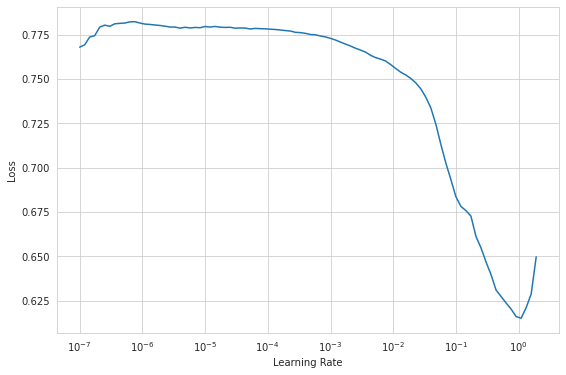

In [99]:
learn.lr_find()

In [100]:
lr= 1e-1

In [101]:
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.349062,0.236261,0.723361,0.337560,0.342720,0.685714,0.673418,0.110000,00:04


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.3375601732292489.


In [102]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

Path('data/classification/standard_themes/css/models/bwd_cls_last_ft_multilabel.pth')

In [103]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lr_max=slice(5e-2/(2.6**4), 5e-2), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.218609,0.184676,0.901639,0.495216,0.442545,0.597403,0.749126,0.160000,00:05


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.49521639873273937.


In [104]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

Path('data/classification/standard_themes/css/models/bwd_cls_last2_ft_multilabel.pth')

In [105]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, lr_max=slice(1e-2/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.176110,0.174335,0.908197,0.529620,0.466120,0.636364,0.772981,0.180000,00:05


Better model found at epoch 0 with fbeta_score value: 0.5296202597991676.


In [106]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

Path('data/classification/standard_themes/css/models/bwd_cls_last3_ft_multilabel.pth')

In [107]:
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=slice(5e-3/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.163506,0.173575,0.915369,0.530004,0.484589,0.602597,0.762422,0.200000,00:06
1,0.161314,0.171010,0.918238,0.539168,0.496346,0.607792,0.766593,0.200000,00:06
2,0.156410,0.169953,0.926434,0.543179,0.538266,0.558442,0.752274,0.250000,00:06
3,0.148719,0.168246,0.920082,0.556271,0.508937,0.628571,0.779101,0.220000,00:06
4,0.137156,0.172879,0.916803,0.557345,0.537626,0.625974,0.777972,0.210000,00:06
5,0.122783,0.177942,0.927254,0.567243,0.573193,0.589610,0.768625,0.230000,00:06
6,0.109109,0.179782,0.912705,0.574915,0.520633,0.680519,0.801315,0.140000,00:06
7,0.094532,0.183499,0.926844,0.579539,0.579282,0.612987,0.776708,0.200000,00:07
8,0.082437,0.190492,0.929098,0.580259,0.564931,0.620779,0.782670,0.180000,00:06
9,0.071755,0.195938,0.929713,0.594769,0.576945,0.631169,0.788819,0.210000,00:06


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.5300043659117137.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with fbeta_score value: 0.5391675899170923.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with fbeta_score value: 0.5431790751270585.
Better model found at epoch 3 with fbeta_score value: 0.5562710982508963.
Better model found at epoch 4 with fbeta_score value: 0.5573448194188998.
Better model found at epoch 5 with fbeta_score value: 0.5672432082271033.
Better model found at epoch 6 with fbeta_score value: 0.5749154366447831.
Better model found at epoch 7 with fbeta_score value: 0.5795386895692498.
Better model found at epoch 8 with fbeta_score value: 0.5802589641501356.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 9 with fbeta_score value: 0.5947685093120598.
Better model found at epoch 13 with fbeta_score value: 0.6014920339174146.


In [108]:
learn.loss_func.thresh

0.13

In [109]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/standard_themes/css/models/bwd_cls_multilabel.pth')

Export model for inference

In [110]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [111]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [112]:
learn.validate() # ... returns [loss, metrics]

(#7) [0.21413658559322357,0.9237704873085022,0.5915298905169228,0.5543609159967459,0.6571428571428571,0.7970340450180332,0.13]

In [113]:
# learn.show_results(max_n=4, trunc_at=60) #=> throws an exception right now!!!

In [114]:
interp = Interpretation.from_learner(learn)

In [115]:
interp.plot_top_losses(k=5)

,input,target,predicted,probability,loss
0,"xxbos xxmaj the xxup mta office is too slow , and did n't understand our scientific or educational needs . i requested an xxup mta to receive a materials ( a non - xxunk strain of bacteria ) that would be used in an instructional lab . xxmaj the initial xxup mta from the sending institution was edited by the xxup ucsd xxup mta office so that it actually put xxup more xxup restrictions on what we at xxup ucsd could do with the materials , and there was general misunderstanding about the nature of the scientific work the material would be used for ( laboratory evolution of the bacterial strain so that they would end up slightly different from the starting material ) . xxmaj from an educational perspective , the xxup mta office was dismissive of the likelihood that student - generated research in a class could lead",knowledgeable_staff;responds_to_requests_within_an_acceptable_time;understands_my_needs_and_requirements,process_improvement,0.4212849736213684,1.6569147109985352
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,overall_satisfaction,cost_fees,0.9999039173126221,1.1245498657226562
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,provides_training_on_processes_applications,helpful_staff;knowledgeable_staff;responds_to_requests_within_an_acceptable_time,0.9490951895713806,1.0237103700637817
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,accessible_to_customers,courte

Use it for inference

In [116]:
inf_learn = load_learner(STANDARD_THEME_CSS_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [117]:
inf_learn.loss_func.thresh

0.13

In [118]:
inf_learn.predict('I feel very uncomfortable talking to my supervisor even though she loves dogs. Help!!!', 
                  with_input=True)

('xxbos i feel very uncomfortable talking to my supervisor even though she loves dogs . xxmaj help xxrep 3 !',
 (#1) ['courteous_professional_staff'],
 tensor([False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False]),
 tensor([2.7216e-02, 9.8696e-05, 2.3344e-05, 4.0426e-01, 3.8626e-06, 1.9960e-06,
         8.7554e-02, 8.3178e-06, 2.8400e-06, 4.7622e-03, 4.2941e-05, 5.8982e-04,
         1.6994e-07, 1.8990e-05, 1.3876e-03, 1.0264e-03]))

Review final validation loss for best model

In [119]:
print(STANDARD_THEME_CSS_LABELS)

['accessible_to_customers', 'consistency_in_policies_information', 'cost_fees', 'courteous_professional_staff', 'effective_communications', 'effectively_uses_websites_online_documentation', 'helpful_staff', 'knowledgeable_staff', 'moving_in_a_positive_direction', 'overall_satisfaction', 'process_improvement', 'provides_effective_advice_guidance', 'provides_training_on_processes_applications', 'resolves_problems_effectively', 'responds_to_requests_within_an_acceptable_time', 'understands_my_needs_and_requirements']


In [120]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [121]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.21413658559322357


In [122]:
learn.predict("I feel very unsafe and threatened here. I HATE my life!!!")

((#1) ['overall_satisfaction'],
 tensor([False, False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False]),
 tensor([1.2249e-02, 6.6811e-06, 3.0120e-05, 2.7272e-02, 3.0848e-06, 5.1157e-08,
         1.0676e-01, 3.8666e-08, 1.5519e-04, 5.2236e-01, 3.2610e-04, 3.9097e-06,
         1.4303e-08, 4.5188e-03, 3.3166e-05, 1.9875e-04]))

## Review

### Lets look at validation metrics

In [123]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
raw_inputs, probs, targs  = learn.get_preds(with_input=True)

len(raw_inputs), probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

(305, torch.Size([305, 16]), torch.Size([305, 16]), 305, 16, 0.13)

In [124]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [125]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.44000000000000006, 0.15000000000000002, 0.05)

In [126]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.6211858541616394, 0.6014920339174146, 0.6417143108580563)

In [127]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f1), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.6014920339174146

In [128]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9413934350013733, 0.9284836053848267, 0.8954917788505554)

In [129]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

0.9284836053848267

### Overall metrics

In [130]:
eval_targs = targs.flatten() # targs[:,0]
eval_probs = probs.flatten() # probs[:,0]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [131]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f1), sample_weight=sample_weight))

0.3836065573770492


In [132]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight))

0.928483606557377


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [133]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 4495


In [134]:
most_freq_class_count / len(eval_targs)

0.9211065573770492

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [135]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float(), 
                            weights=None, sample_weight=sample_weight))

0.5520792787485403


#### Confusion Matrix

Describes the performance of a classification model

In [136]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [137]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight)

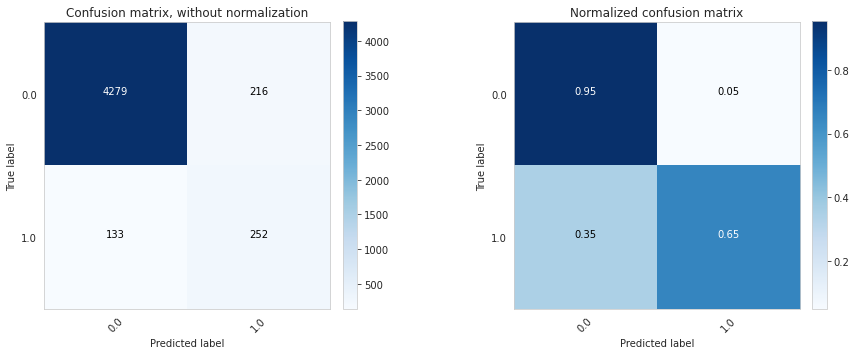

In [138]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [139]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f1).float(), [0,1], 
                                sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4495
           1       0.54      0.65      0.59       385

    accuracy                           0.93      4880
   macro avg       0.75      0.80      0.78      4880
weighted avg       0.94      0.93      0.93      4880



/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

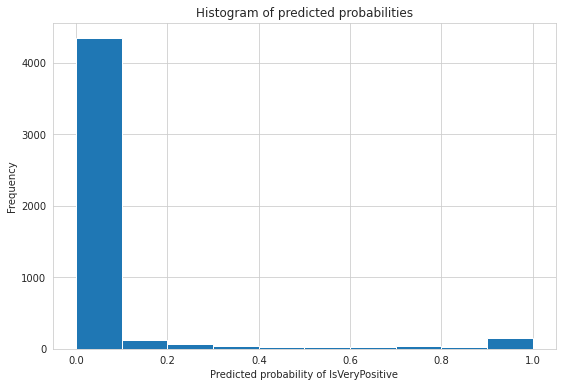

In [140]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [141]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

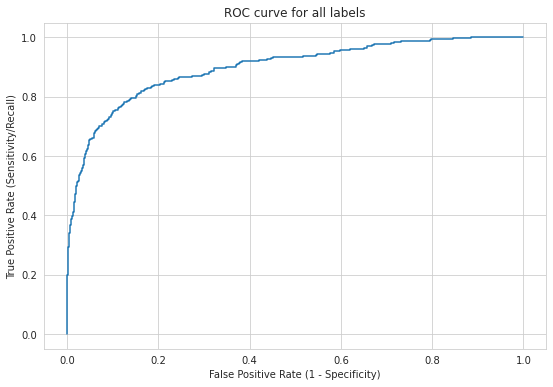

In [142]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [143]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.8978460916169481


### Let's look at things by label by label

In [144]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_CSS_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [145]:
# label_metrics

ACCESSIBLE_TO_CUSTOMERS

Null Accuracy:	0.8885245901639345
AUC Score:	0.8554373779031907

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.8918032786885246	0.8590163934426229	0.8065573770491803	
Cohen's Kappa:	0.41628486922229313	0.4396496475112156	0.349680170575693	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9312              0.9483              0.9397              271                 
1                   0.5172              0.4412              0.4762              34                  
avg/total           0.7242              0.6948              0.7079              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.956               0.8819              0.9175              271                 
1                   0.4182              0.6765              0.5169       

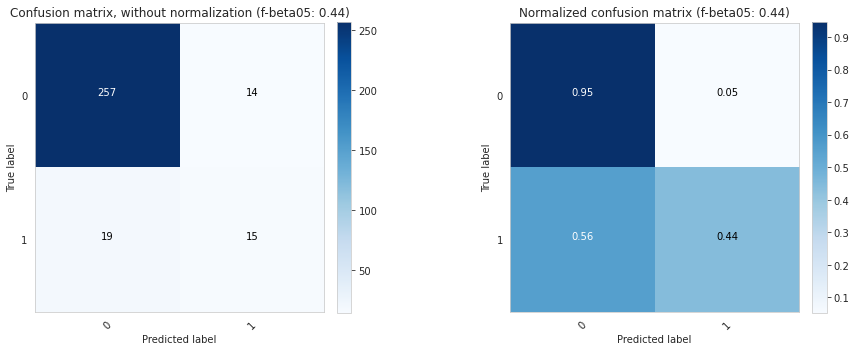

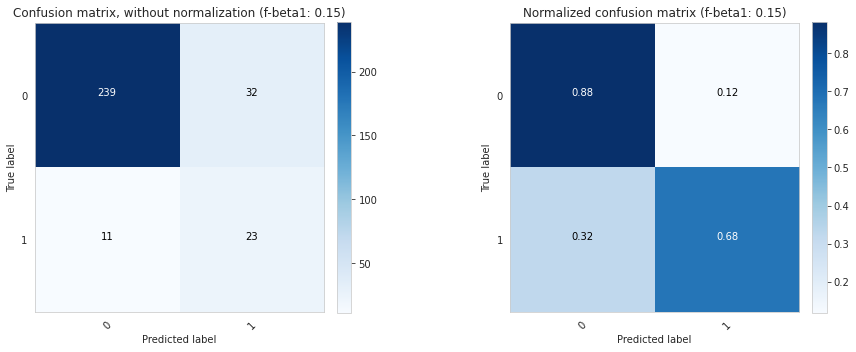

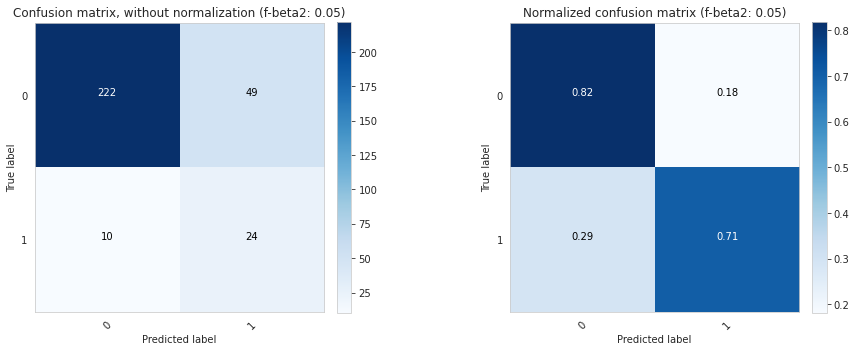



ROC Curve:


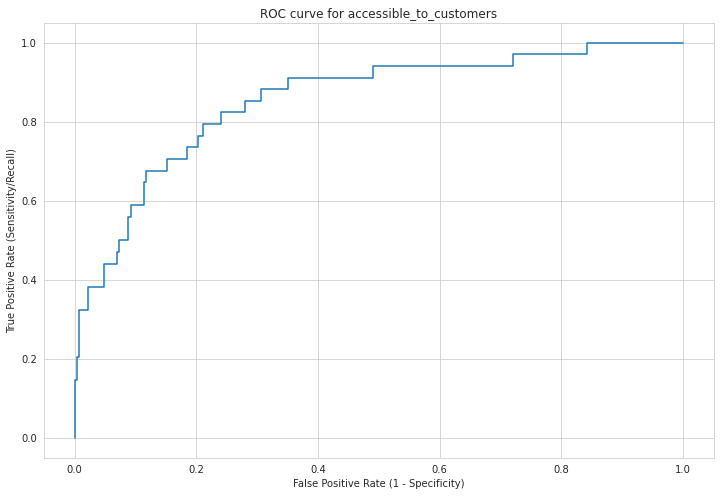

Predicted Probability Distribution:


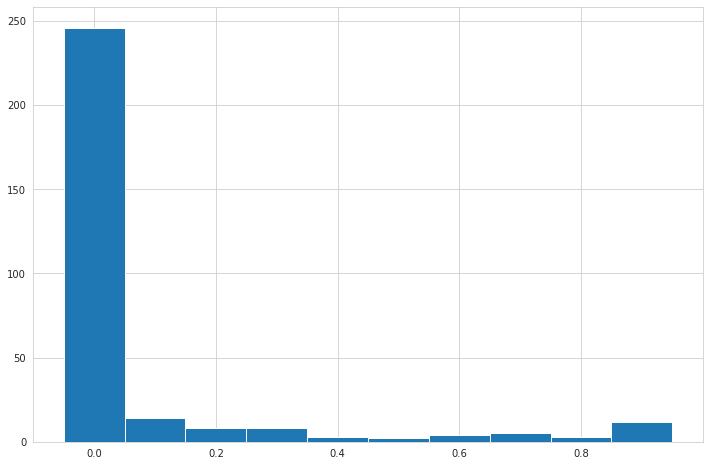



----------------------------------------------------------------------------------------------------


CONSISTENCY_IN_POLICIES_INFORMATION

Null Accuracy:	0.9737704918032787
AUC Score:	0.853956228956229

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9704918032786886	0.9672131147540983	0.9475409836065574	
Cohen's Kappa:	0.16994254611430304	0.15183537263626257	0.08442776735459656	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9768              0.9933              0.985               297                 
1                   0.3333              0.125               0.1818              8                   
avg/total           0.6551              0.5591              0.5834              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9767              0.9899         

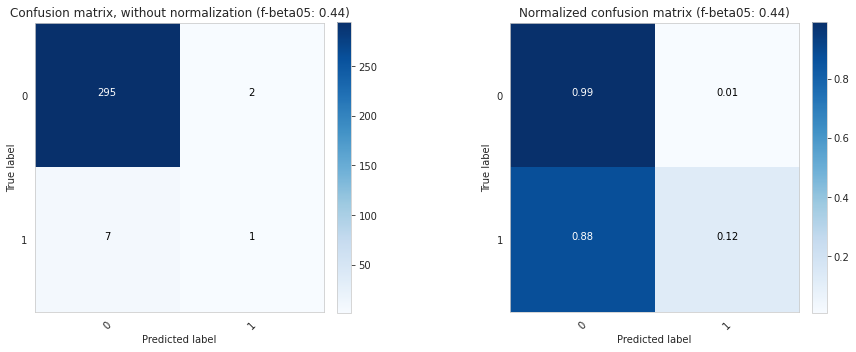

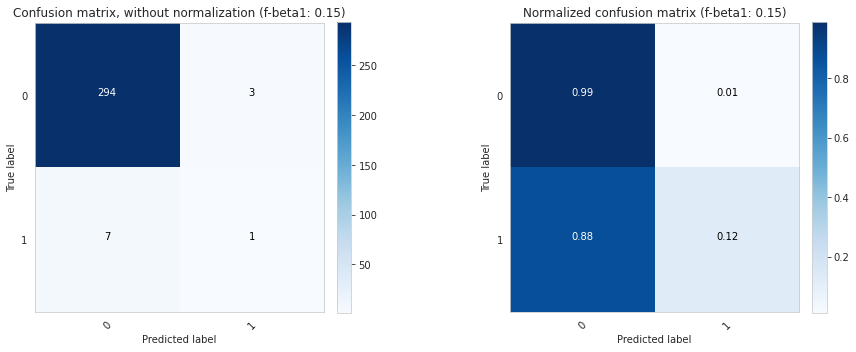

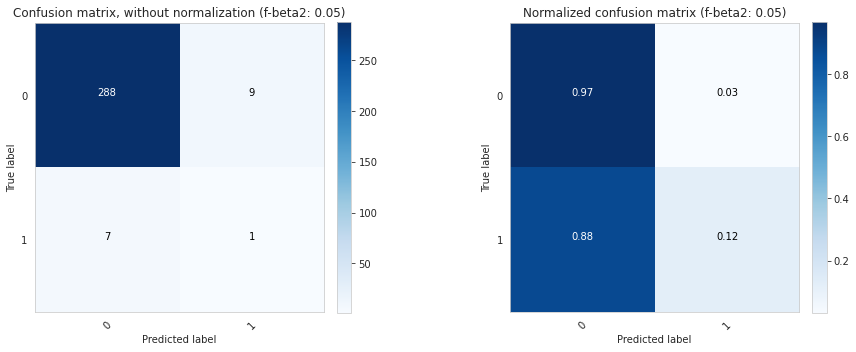



ROC Curve:


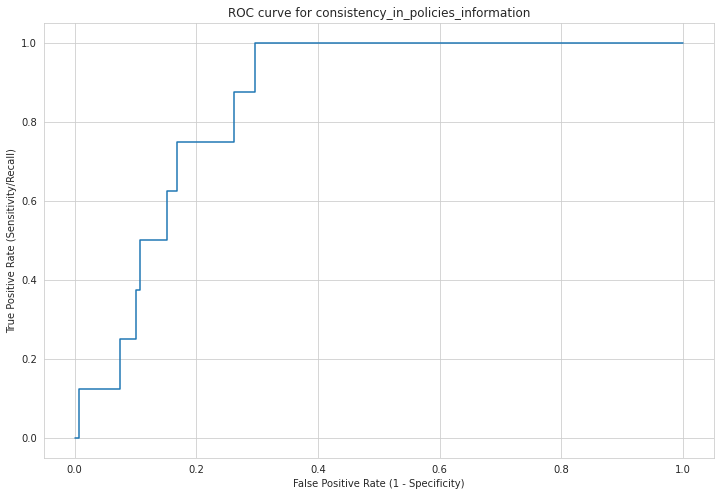

Predicted Probability Distribution:


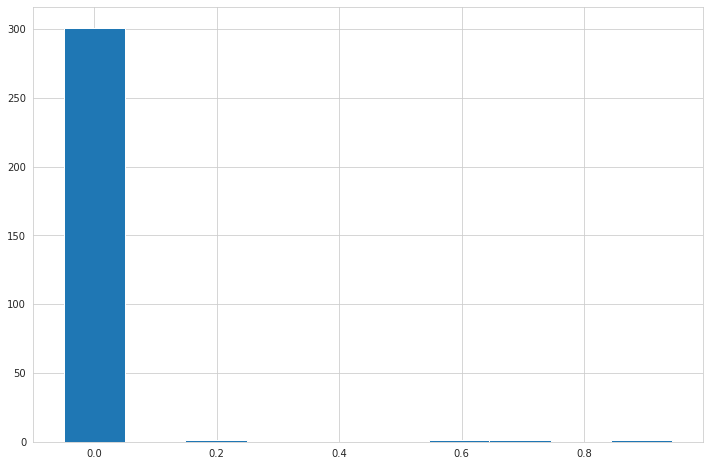



----------------------------------------------------------------------------------------------------


COST_FEES

Null Accuracy:	0.839344262295082
AUC Score:	0.9695471938775511

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9377049180327869	0.9475409836065574	0.940983606557377	
Cohen's Kappa:	0.7459558984700364	0.798845836768343	0.7811702806122449	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9438              0.9844              0.9637              256                 
1                   0.8947              0.6939              0.7816              49                  
avg/total           0.9193              0.8391              0.8726              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9615              0.9766              0.969               256   

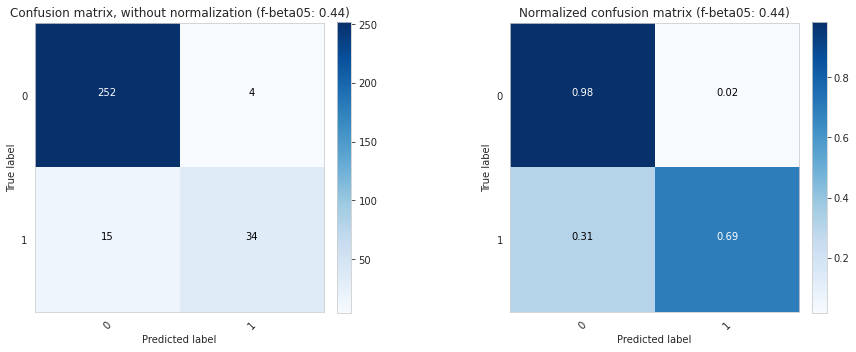

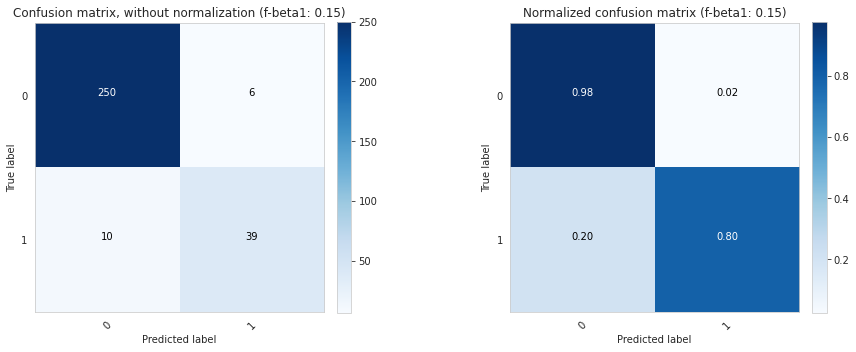

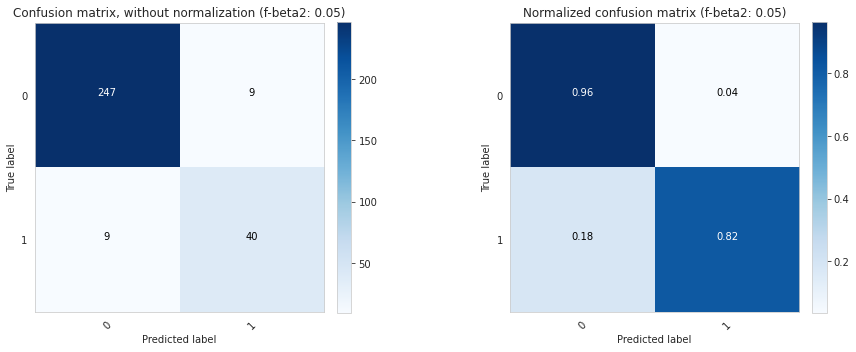



ROC Curve:


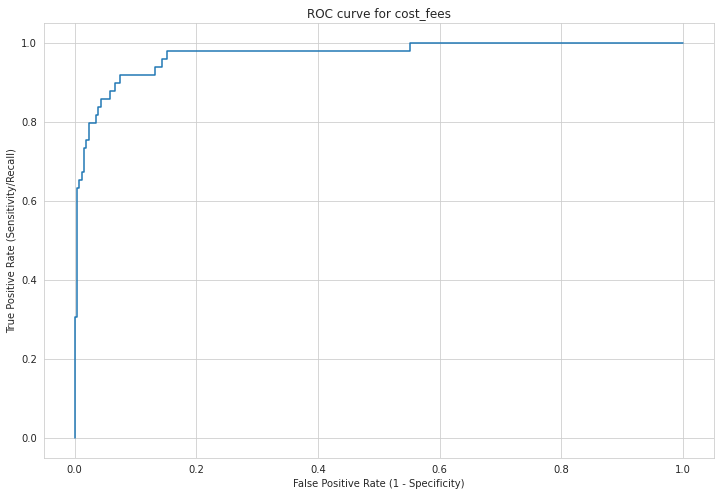

Predicted Probability Distribution:


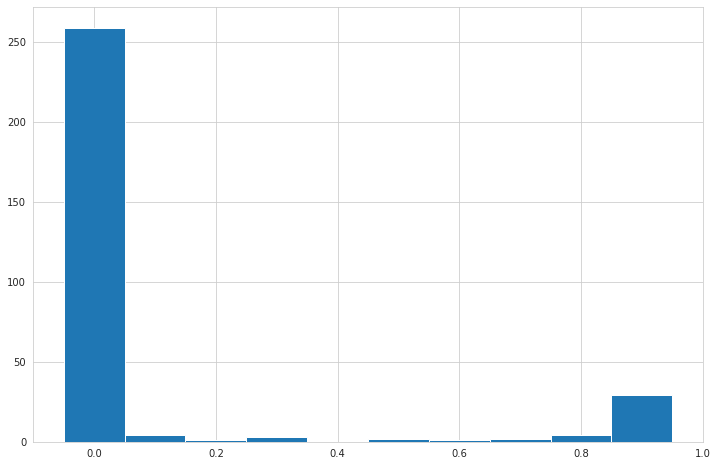



----------------------------------------------------------------------------------------------------


COURTEOUS_PROFESSIONAL_STAFF

Null Accuracy:	0.921311475409836
AUC Score:	0.9191874258600238

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9442622950819672	0.9377049180327869	0.9377049180327869	
Cohen's Kappa:	0.5564205663444264	0.5620134532537223	0.6332510600594898	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9583              0.9822              0.9701              281                 
1                   0.7059              0.5                 0.5854              24                  
avg/total           0.8321              0.7411              0.7777              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9645              0.968               0.966

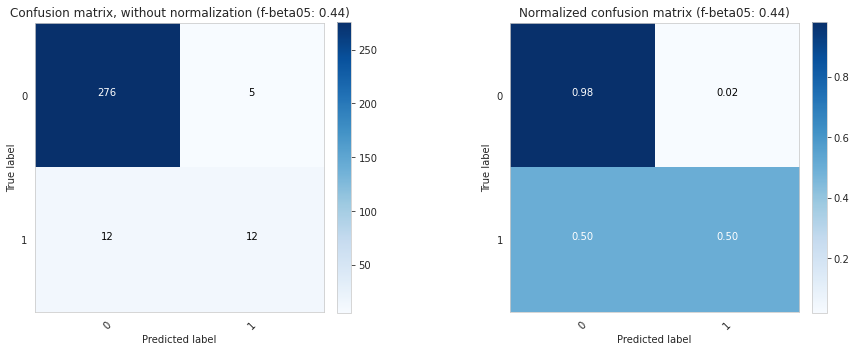

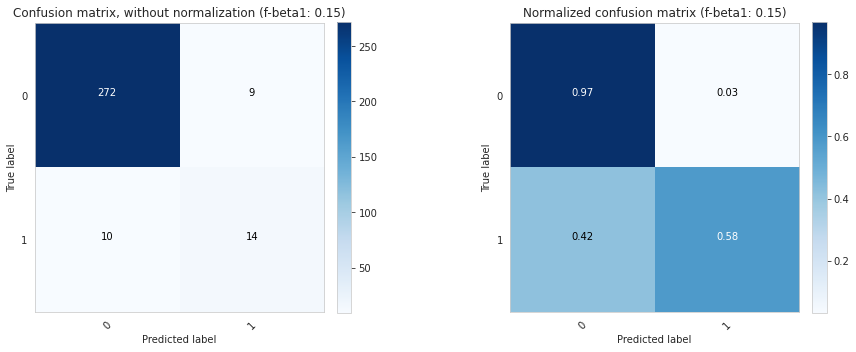

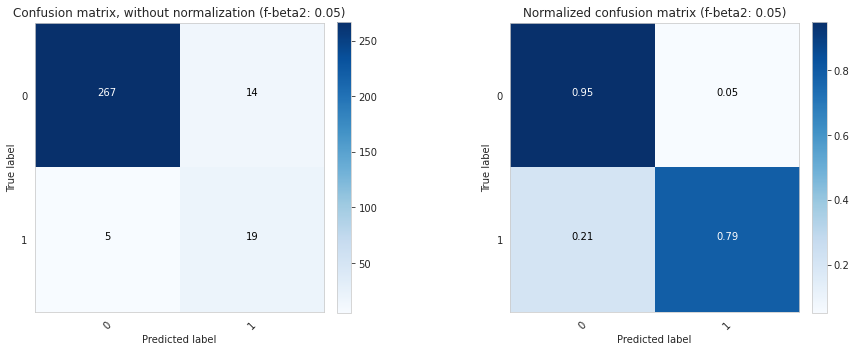



ROC Curve:


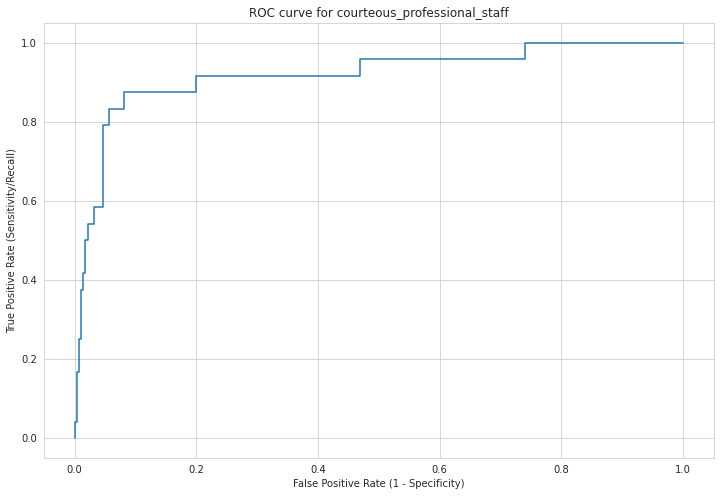

Predicted Probability Distribution:


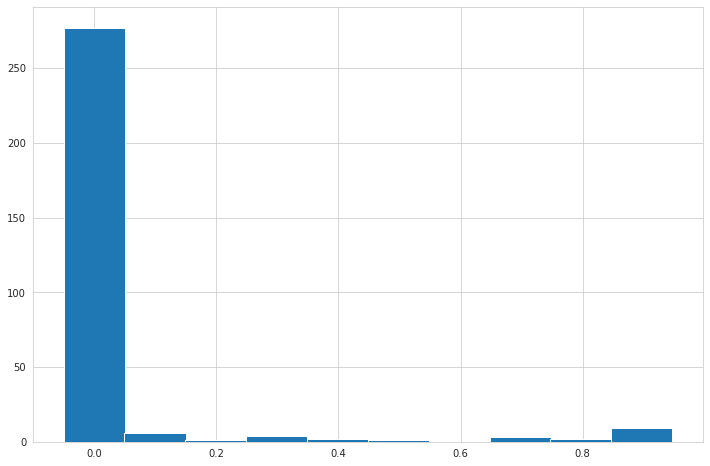



----------------------------------------------------------------------------------------------------


EFFECTIVE_COMMUNICATIONS

Null Accuracy:	0.8754098360655738
AUC Score:	0.9388921742558642

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.921311475409836	0.9180327868852459	0.9114754098360656	
Cohen's Kappa:	0.571579070584104	0.6199471664257588	0.6238867321306234	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9324              0.9813              0.9562              267                 
1                   0.7917              0.5                 0.6129              38                  
avg/total           0.862               0.7406              0.7846              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9515              0.9551              0.9533    

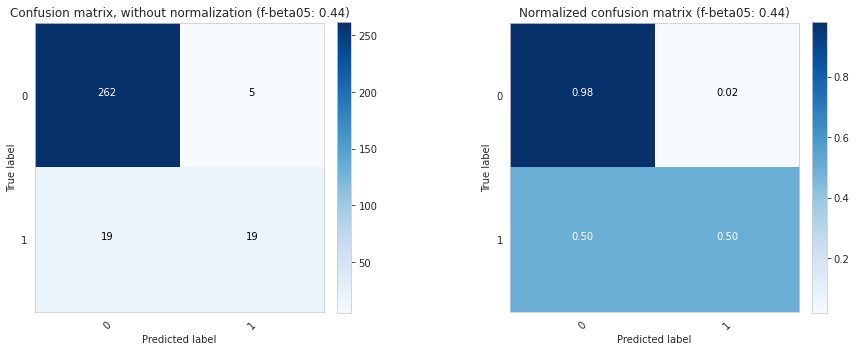

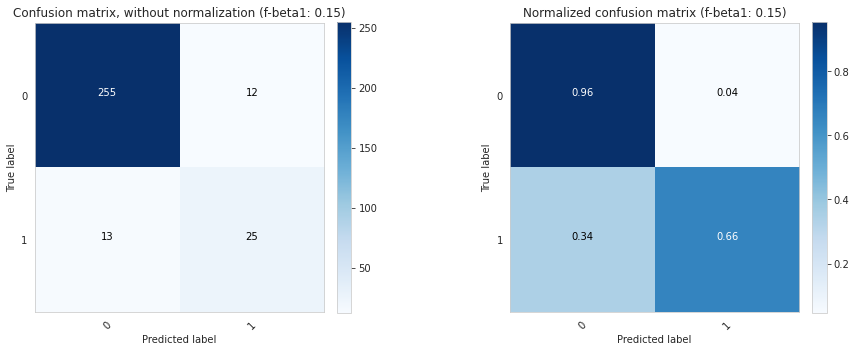

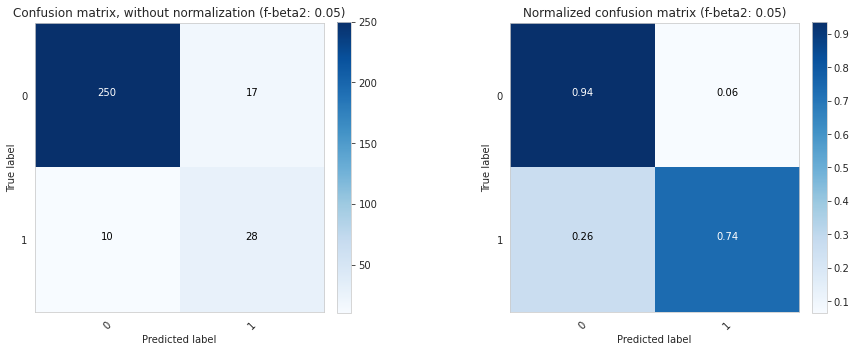



ROC Curve:


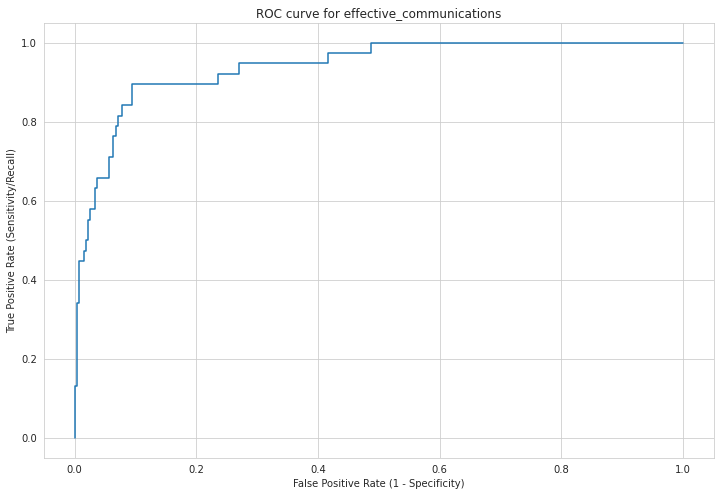

Predicted Probability Distribution:


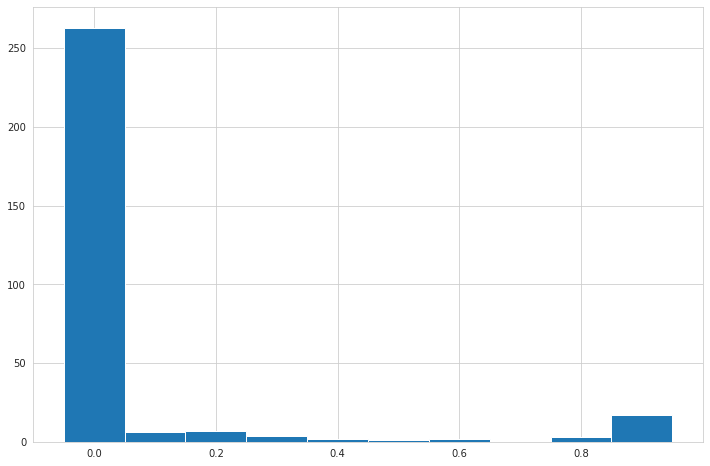



----------------------------------------------------------------------------------------------------


EFFECTIVELY_USES_WEBSITES_ONLINE_DOCUMENTATION

Null Accuracy:	0.8852459016393442
AUC Score:	0.9417989417989417

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9377049180327869	0.9344262295081968	0.9016393442622951	
Cohen's Kappa:	0.681505908216543	0.7191528545119705	0.6198587453261322	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9597              0.9704              0.965               270                 
1                   0.75                0.6857              0.7164              35                  
avg/total           0.8549              0.828               0.8407              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9845              0.9407 

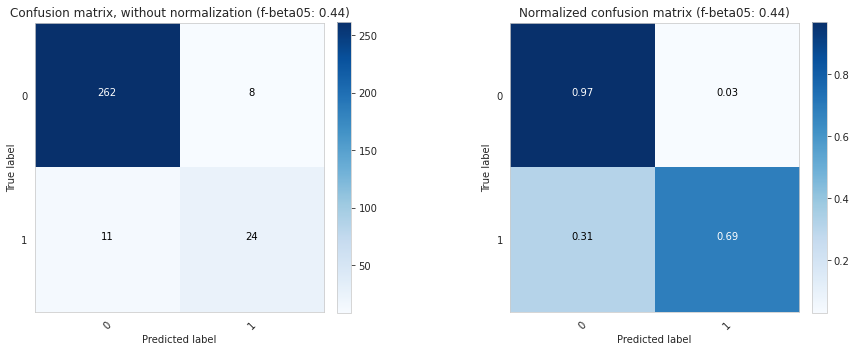

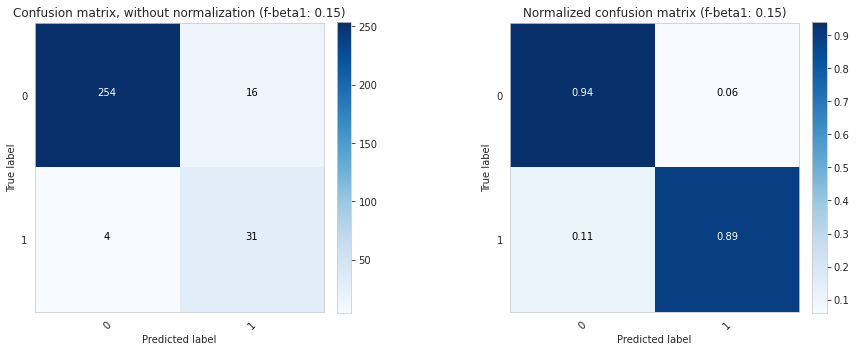

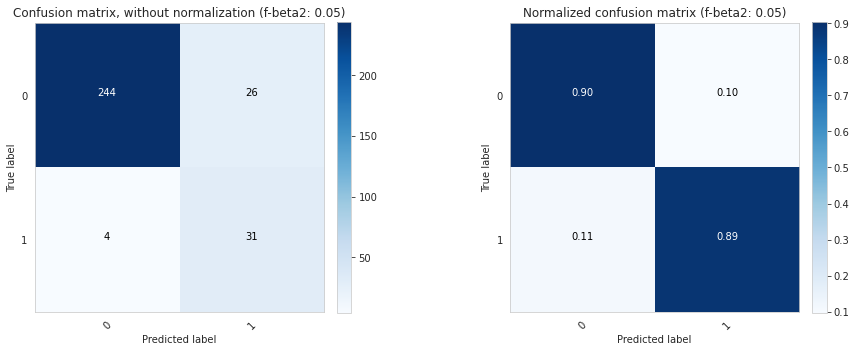



ROC Curve:


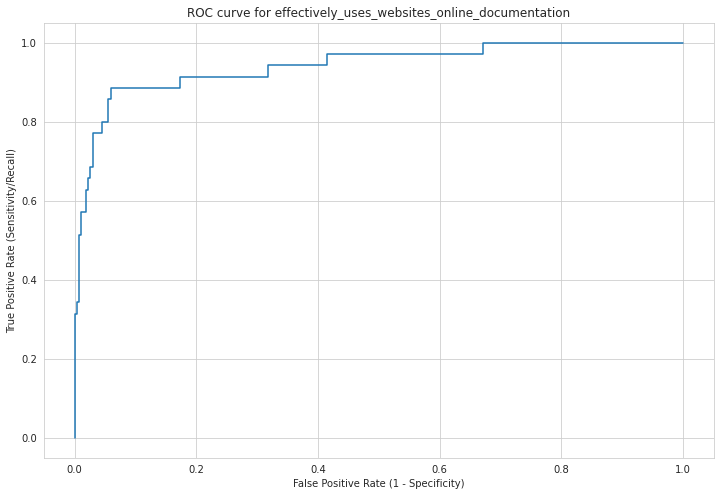

Predicted Probability Distribution:


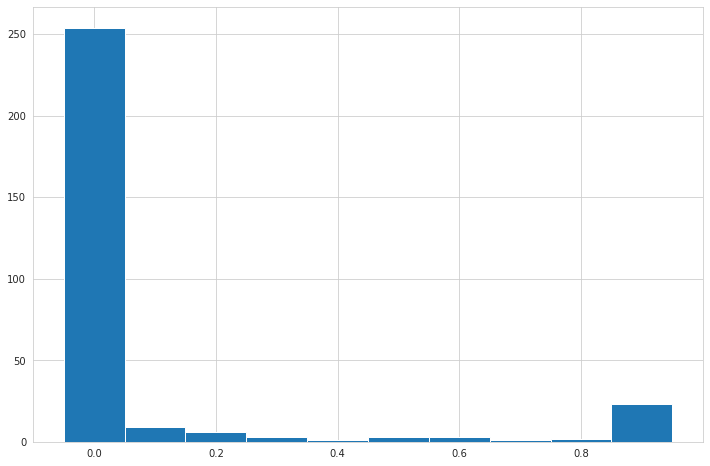



----------------------------------------------------------------------------------------------------


HELPFUL_STAFF

Null Accuracy:	0.940983606557377
AUC Score:	0.8321718931475028

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9278688524590164	0.8819672131147541	0.8163934426229508	
Cohen's Kappa:	0.4118162692847124	0.3243076923076923	0.22952002887044398	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9682              0.9547              0.9614              287                 
1                   0.4091              0.5                 0.45                18                  
avg/total           0.6886              0.7274              0.7057              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9736              0.899               0.9348             

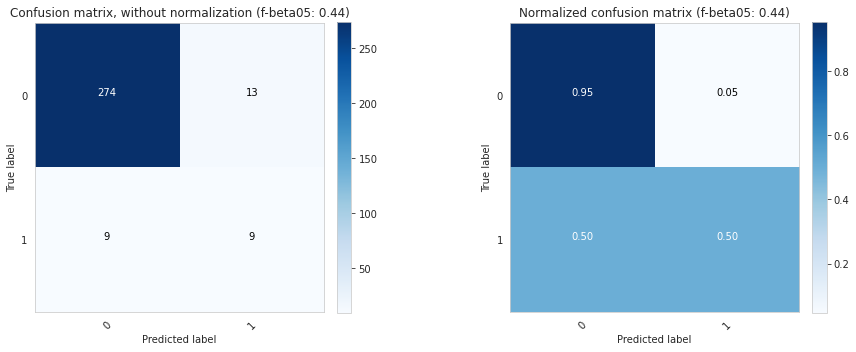

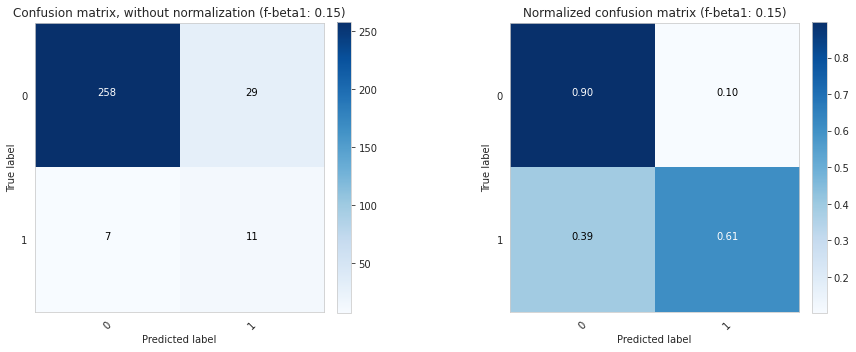

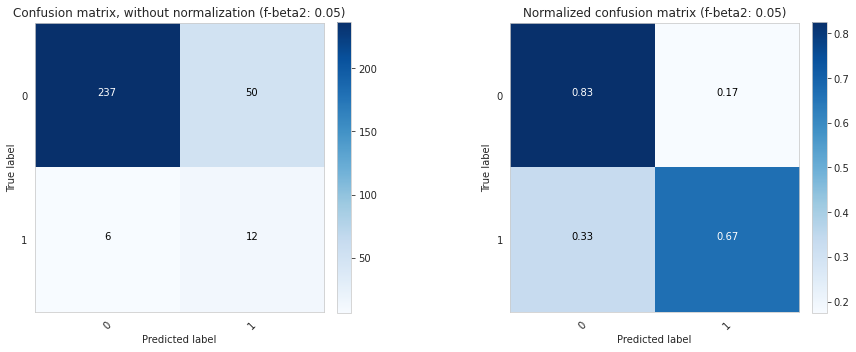



ROC Curve:


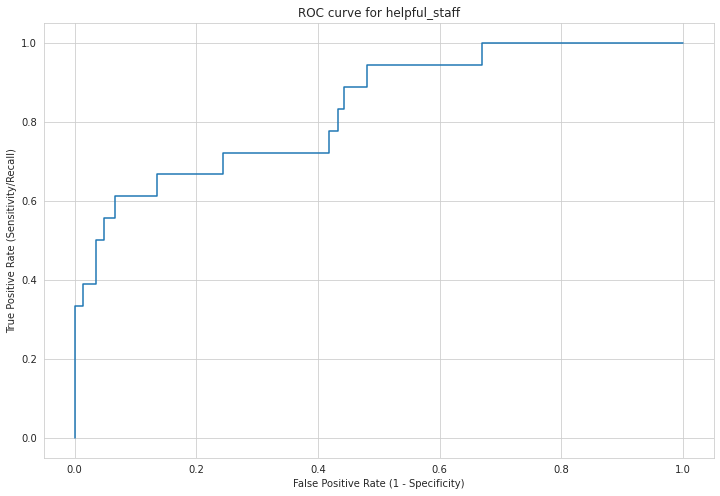

Predicted Probability Distribution:


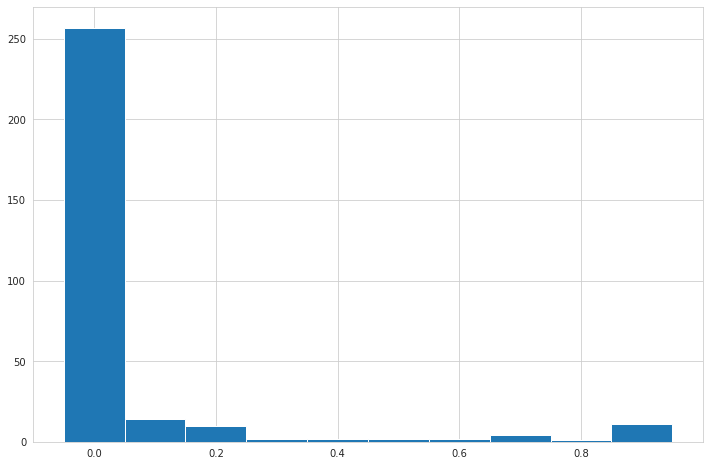



----------------------------------------------------------------------------------------------------


KNOWLEDGEABLE_STAFF

Null Accuracy:	0.9311475409836065
AUC Score:	0.863346747149564

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9344262295081968	0.9114754098360656	0.8786885245901639	
Cohen's Kappa:	0.3046055631554947	0.40191735057012123	0.3722534349446516	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9459              0.9859              0.9655              284                 
1                   0.5556              0.2381              0.3333              21                  
avg/total           0.7508              0.612               0.6494              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9639              0.9401              0.9519       

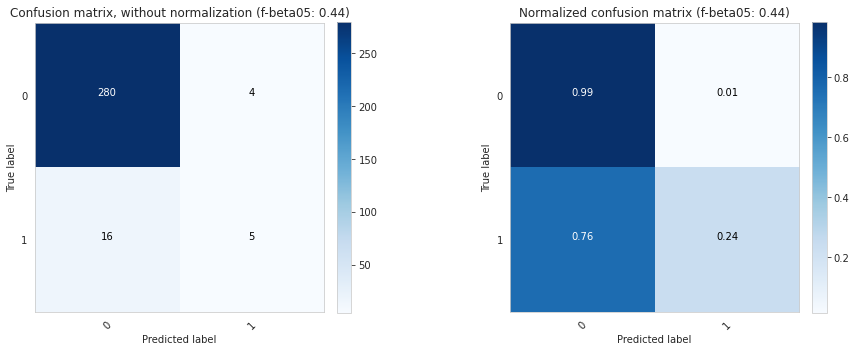

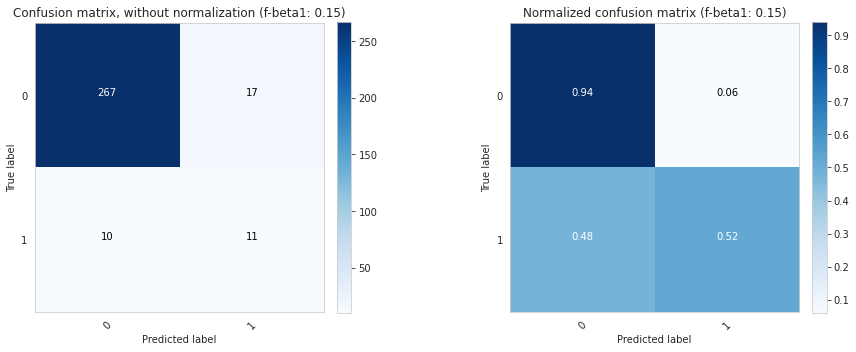

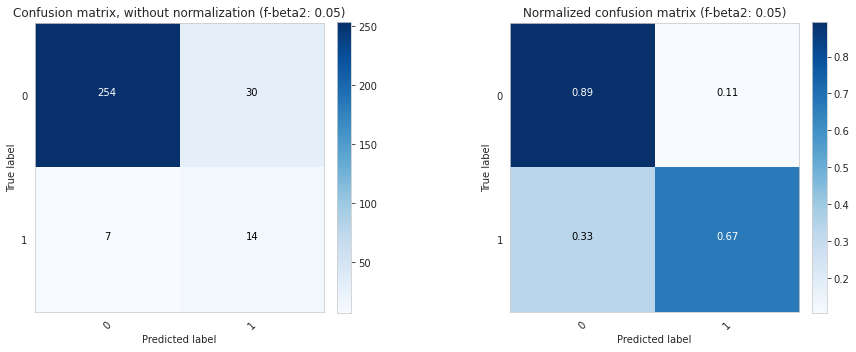



ROC Curve:


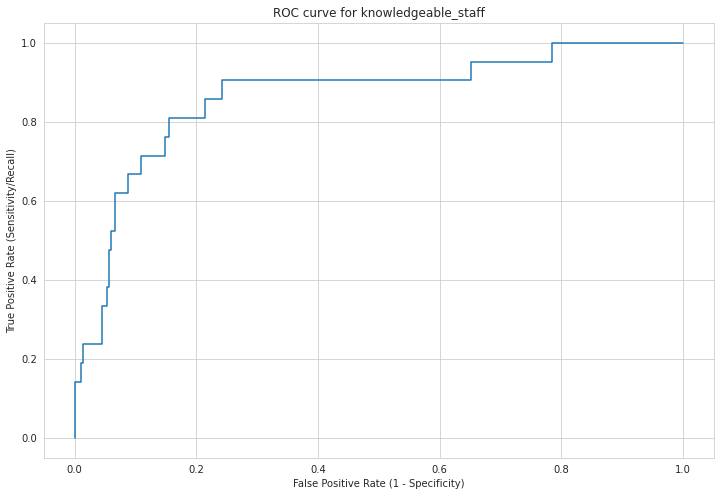

Predicted Probability Distribution:


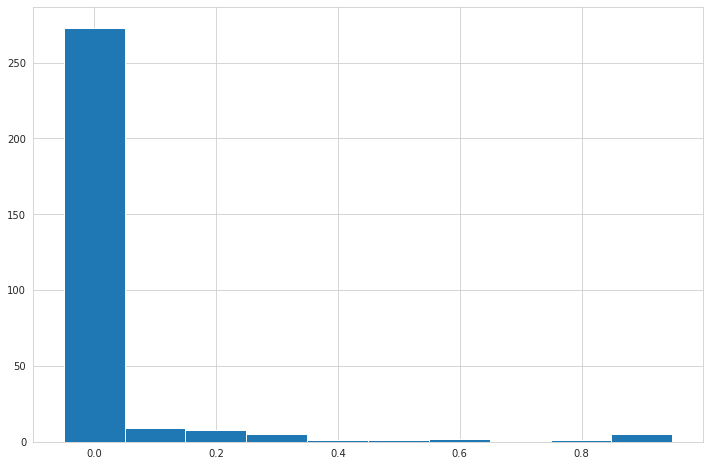



----------------------------------------------------------------------------------------------------


MOVING_IN_A_POSITIVE_DIRECTION

Null Accuracy:	0.9868852459016394
AUC Score:	0.819767441860465

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9934426229508196	0.9934426229508196	0.9770491803278688	
Cohen's Kappa:	0.6637265711135611	0.6637265711135611	0.35283419217944834	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9934              1.0                 0.9967              301                 
1                   1.0                 0.5                 0.6667              4                   
avg/total           0.9967              0.75                0.8317              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9934              1.0                 0.

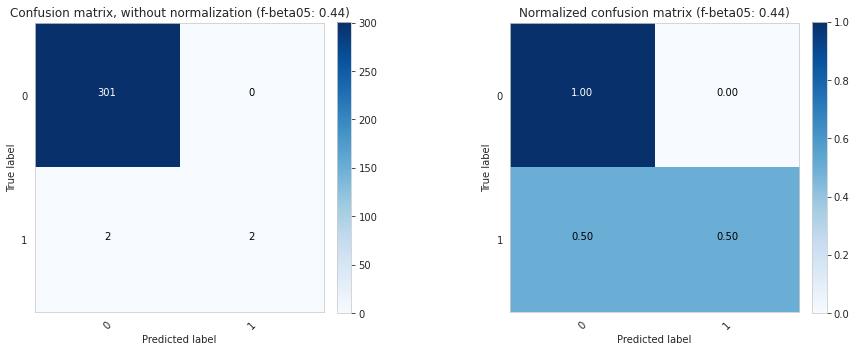

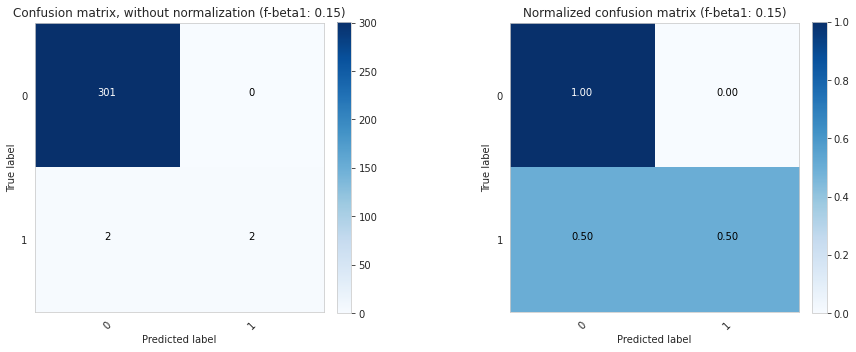

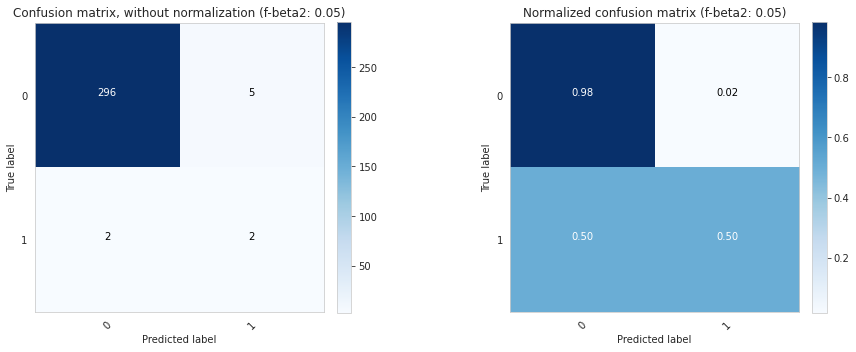



ROC Curve:


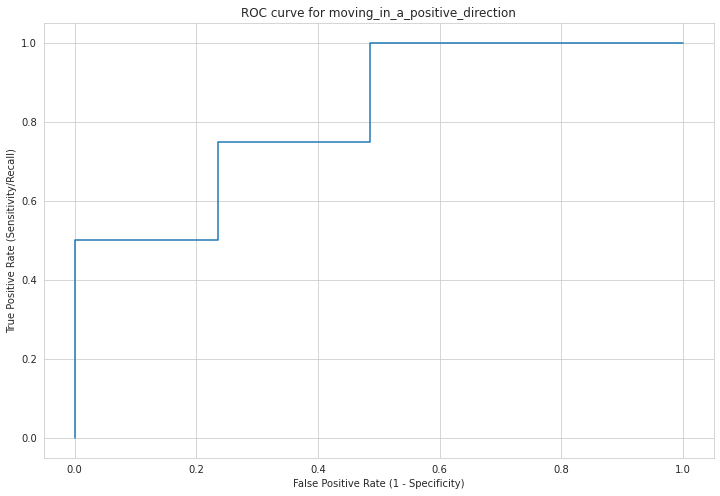

Predicted Probability Distribution:


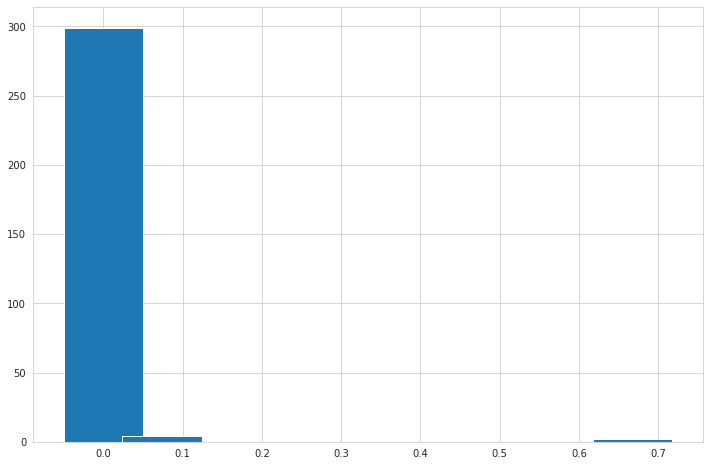



----------------------------------------------------------------------------------------------------


OVERALL_SATISFACTION

Null Accuracy:	0.9114754098360656
AUC Score:	0.9229949373834265

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.940983606557377	0.9278688524590164	0.8918032786885246	
Cohen's Kappa:	0.593513993780542	0.5530242472688516	0.47792935318221896	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9577              0.9784              0.968               278                 
1                   0.7143              0.5556              0.625               27                  
avg/total           0.836               0.767               0.7965              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9604              0.9604              0.9604       

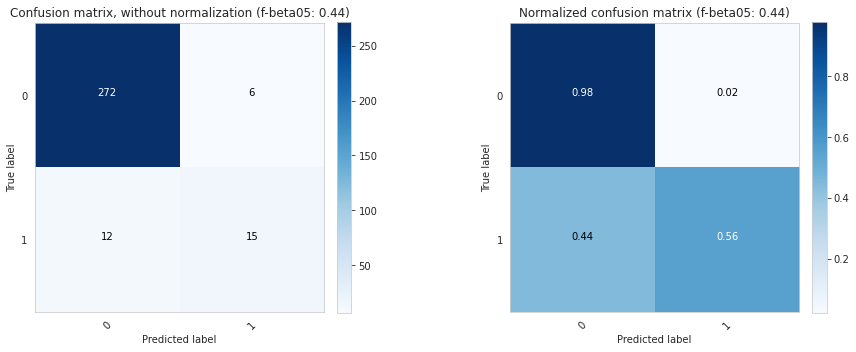

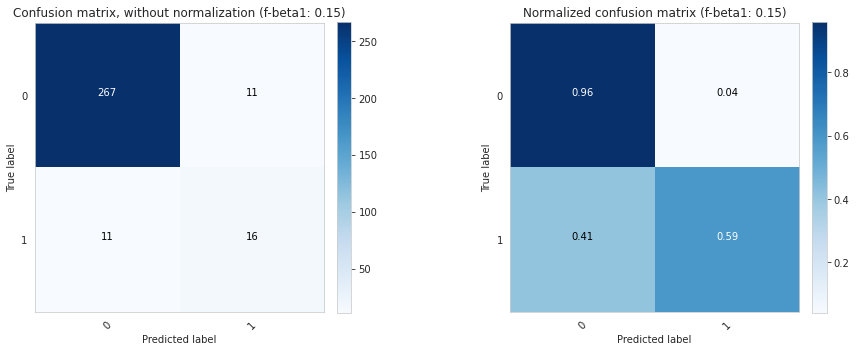

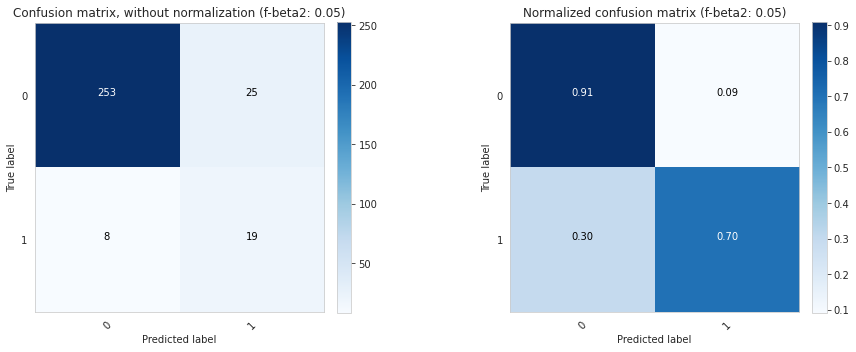



ROC Curve:


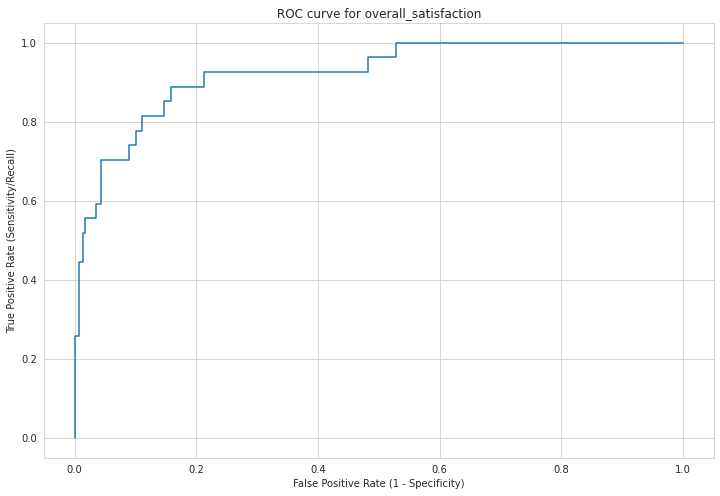

Predicted Probability Distribution:


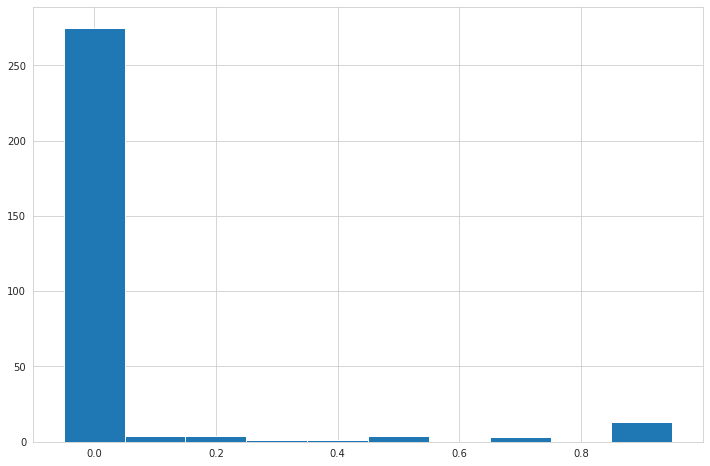



----------------------------------------------------------------------------------------------------


PROCESS_IMPROVEMENT

Null Accuracy:	0.9016393442622951
AUC Score:	0.7892121212121213

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9049180327868852	0.8754098360655738	0.8163934426229508	
Cohen's Kappa:	0.38125218607904865	0.3883905013192612	0.2982744453574363	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9331              0.9636              0.9481              275                 
1                   0.5238              0.3667              0.4314              30                  
avg/total           0.7285              0.6652              0.6897              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9472              0.9127              0.9296      

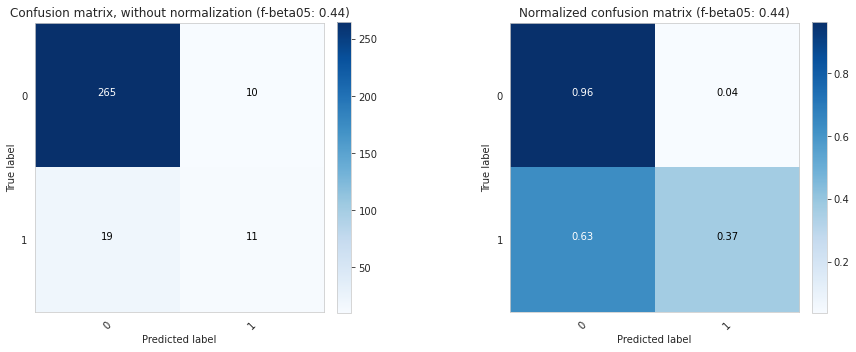

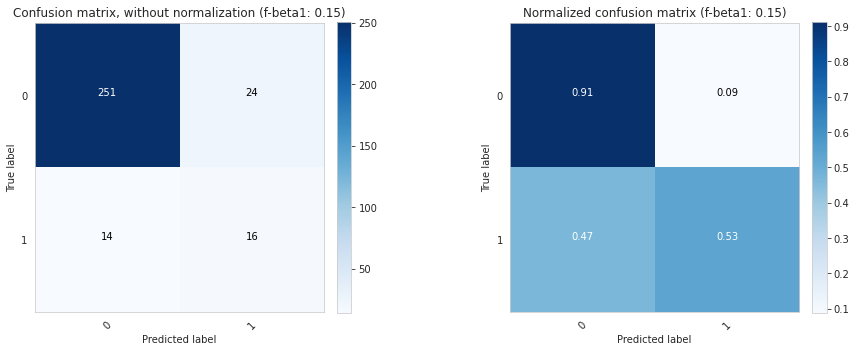

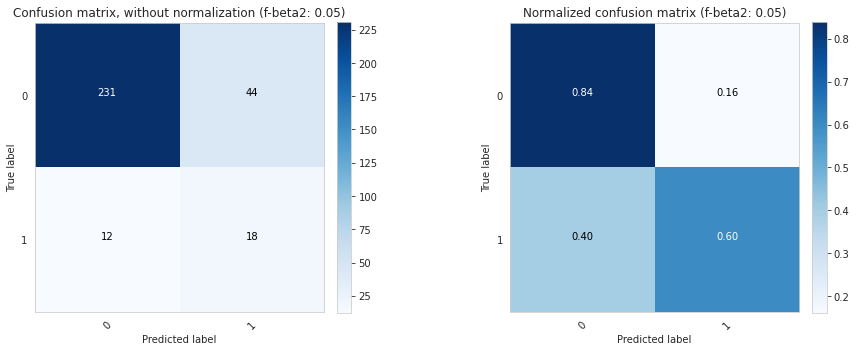



ROC Curve:


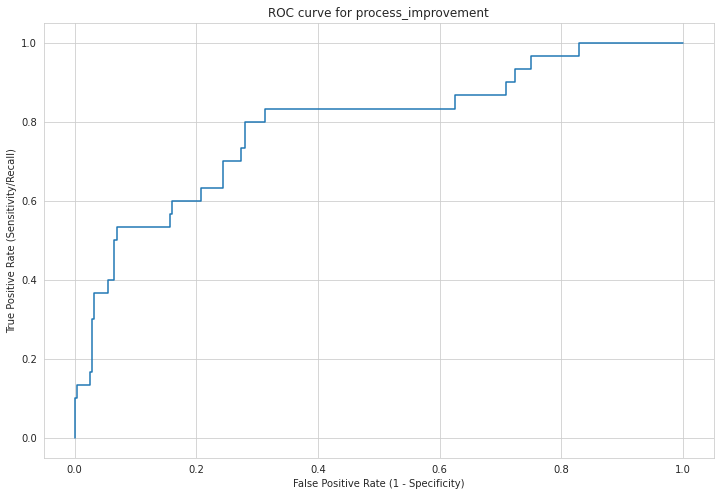

Predicted Probability Distribution:


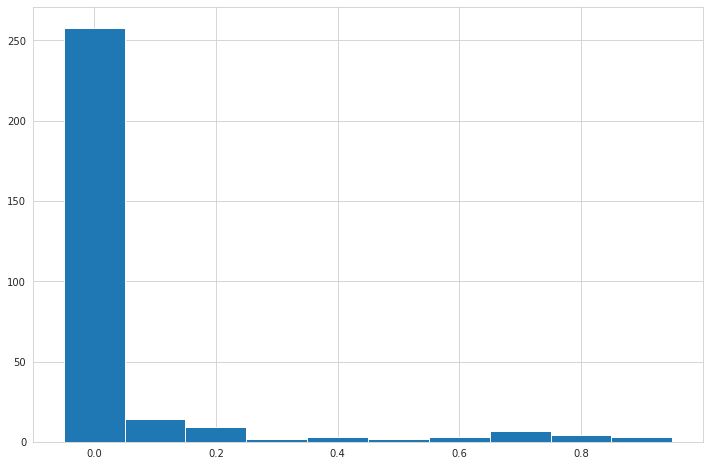



----------------------------------------------------------------------------------------------------


PROVIDES_EFFECTIVE_ADVICE_GUIDANCE

Null Accuracy:	0.9836065573770492
AUC Score:	0.9113333333333333

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.980327868852459	0.9442622950819672	0.8885245901639345	
Cohen's Kappa:	0.39	0.16973578863090466	0.07904085257548854	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.99                0.99                0.99                300                 
1                   0.4                 0.4                 0.4                 5                   
avg/total           0.695               0.695               0.695               305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9896              0.9533              0.9711     

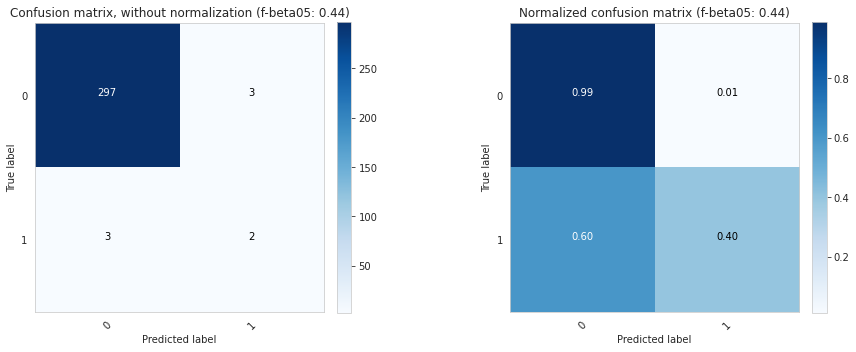

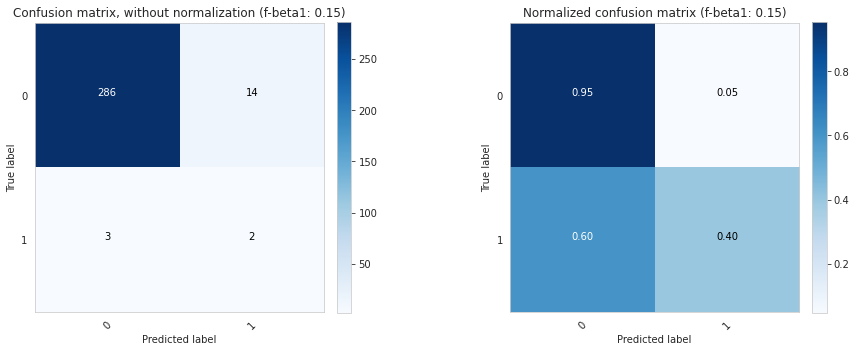

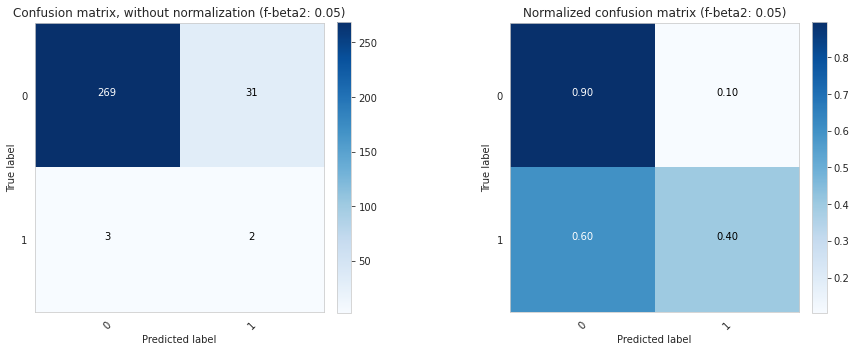



ROC Curve:


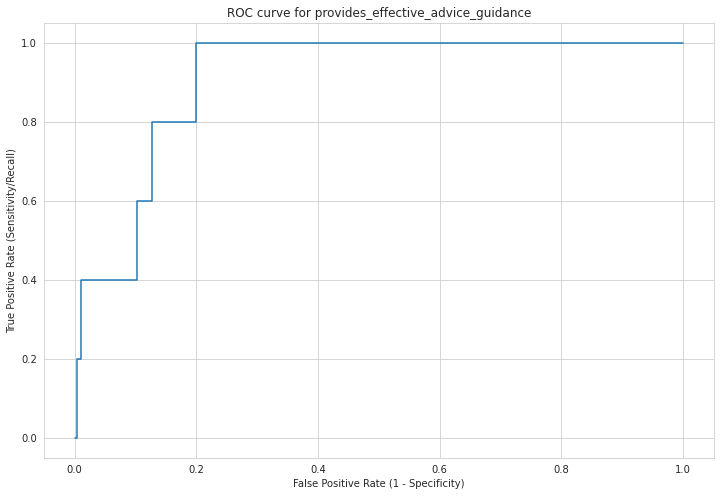

Predicted Probability Distribution:


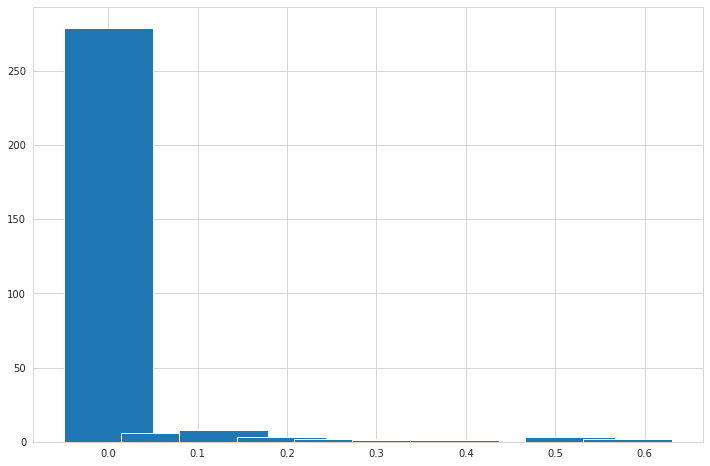



----------------------------------------------------------------------------------------------------


PROVIDES_TRAINING_ON_PROCESSES_APPLICATIONS

Null Accuracy:	0.9737704918032787
AUC Score:	0.7920875420875422

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9737704918032787	0.9672131147540983	0.9475409836065574	
Cohen's Kappa:	0.415428845232391	0.42776735459662285	0.3091732729331823	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9833              0.9899              0.9866              297                 
1                   0.5                 0.375               0.4286              8                   
avg/total           0.7416              0.6824              0.7076              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9864              0.9798   

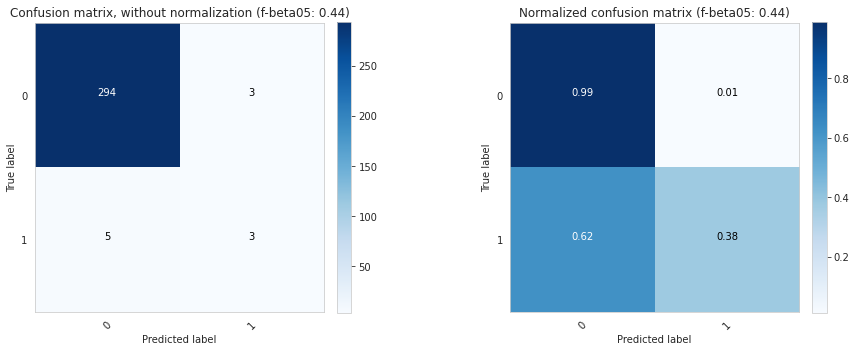

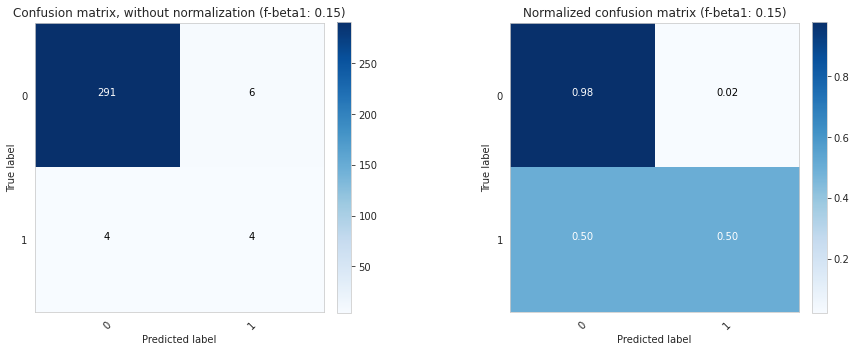

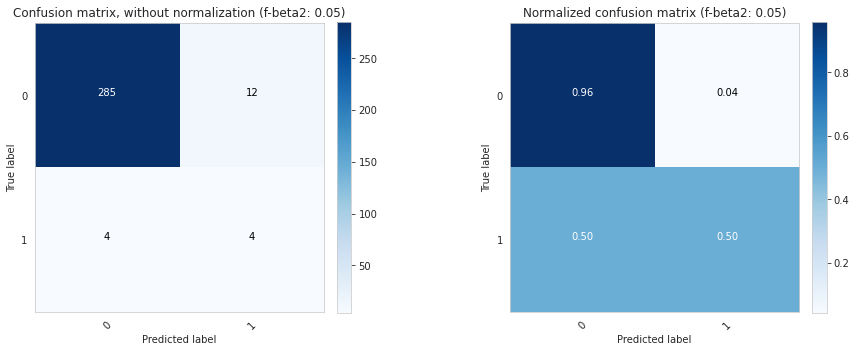



ROC Curve:


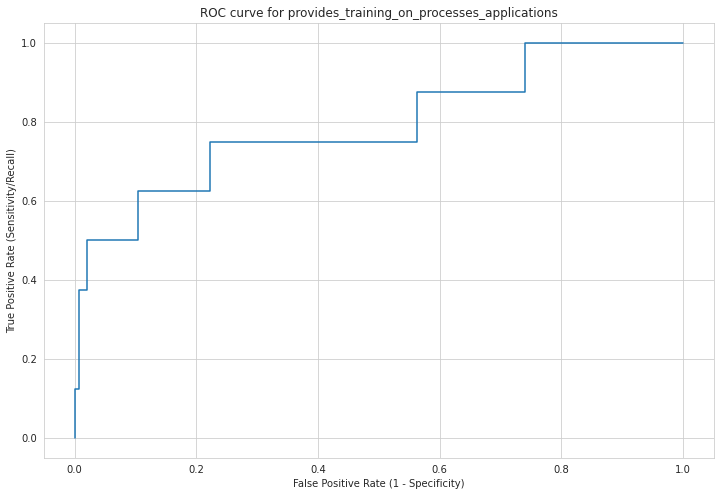

Predicted Probability Distribution:


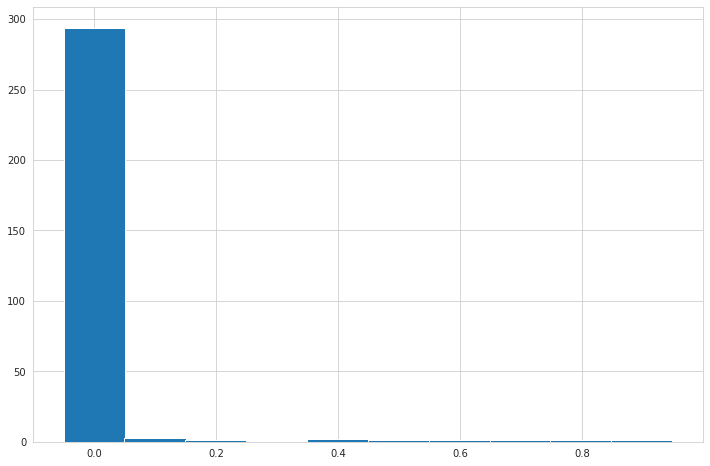



----------------------------------------------------------------------------------------------------


RESOLVES_PROBLEMS_EFFECTIVELY

Null Accuracy:	0.9278688524590164
AUC Score:	0.9153549630581432

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.9344262295081968	0.9245901639344263	0.8590163934426229	
Cohen's Kappa:	0.4652875175315567	0.5572735878826127	0.4068026595504093	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9582              0.9717              0.9649              283                 
1                   0.5556              0.4545              0.5                 22                  
avg/total           0.7569              0.7131              0.7325              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9815              0.9364              0.9

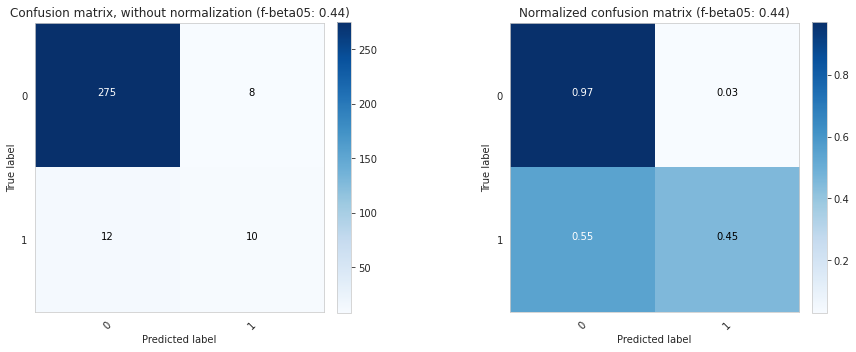

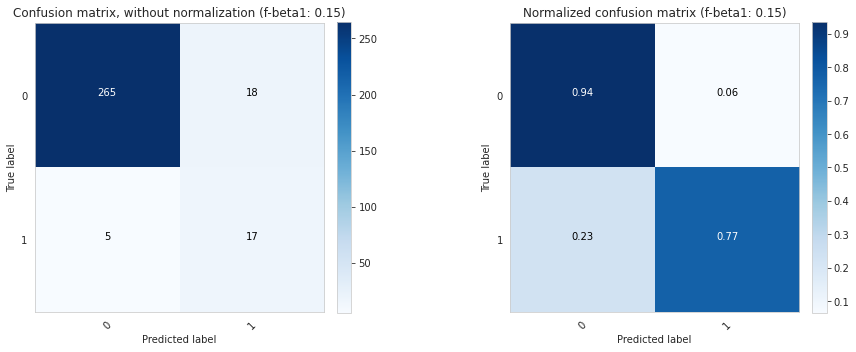

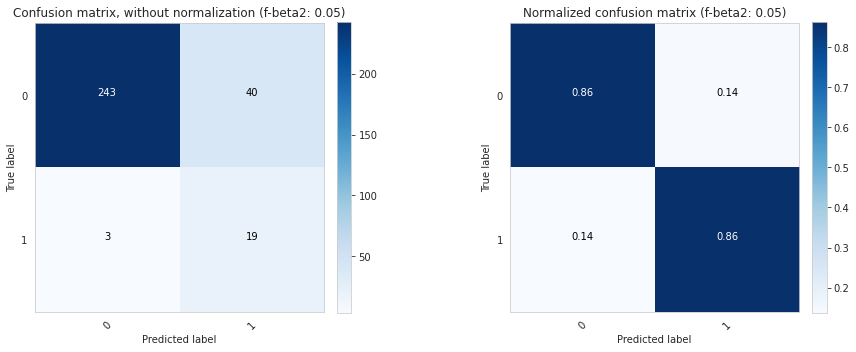



ROC Curve:


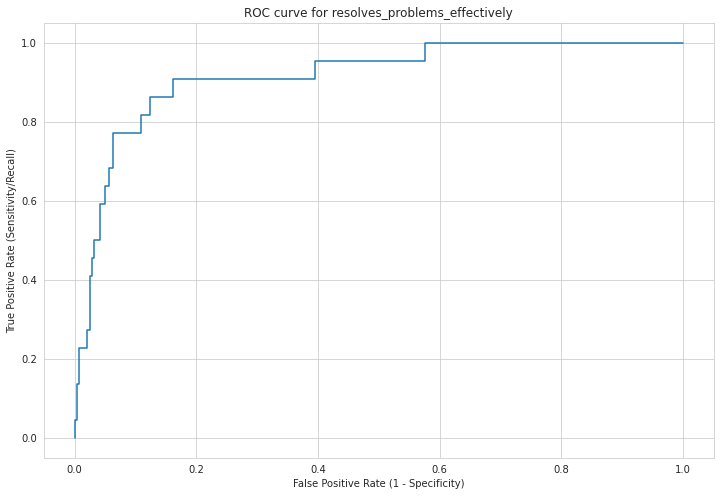

Predicted Probability Distribution:


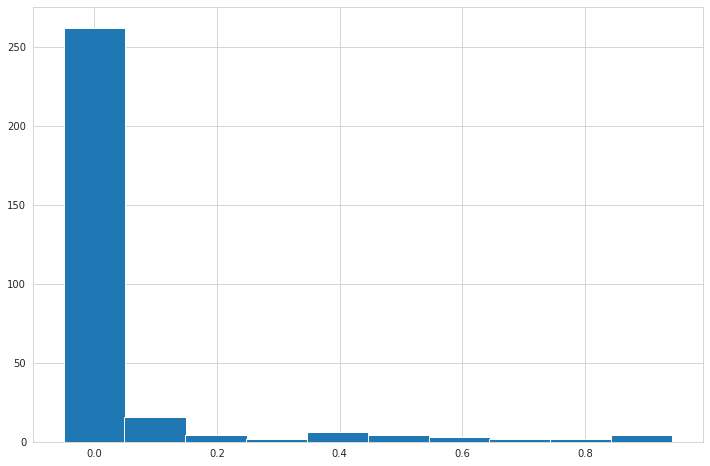



----------------------------------------------------------------------------------------------------


RESPONDS_TO_REQUESTS_WITHIN_AN_ACCEPTABLE_TIME

Null Accuracy:	0.8163934426229508
AUC Score:	0.8875502008032129

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.8885245901639345	0.8918032786885246	0.8622950819672132	
Cohen's Kappa:	0.5882633208925594	0.6415725935686052	0.5915439066386072	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9087              0.9598              0.9336              249                 
1                   0.7619              0.5714              0.6531              56                  
avg/total           0.8353              0.7656              0.7933              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9355              0.9317

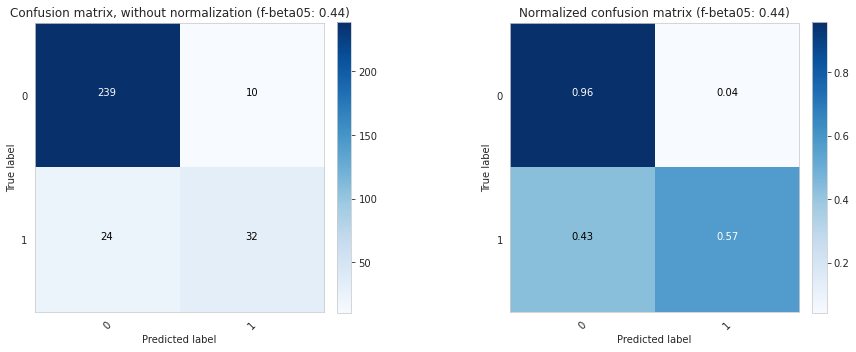

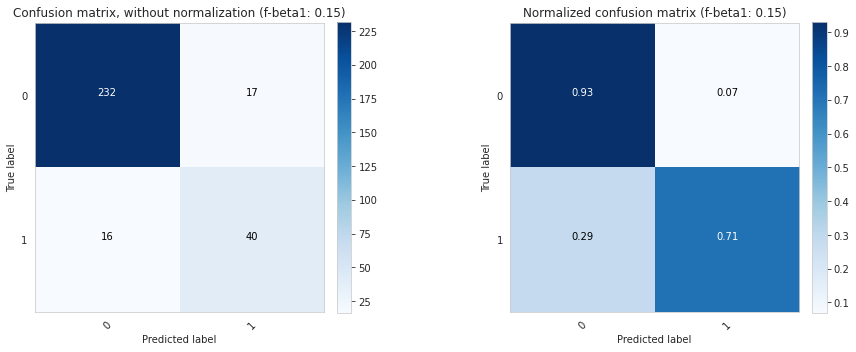

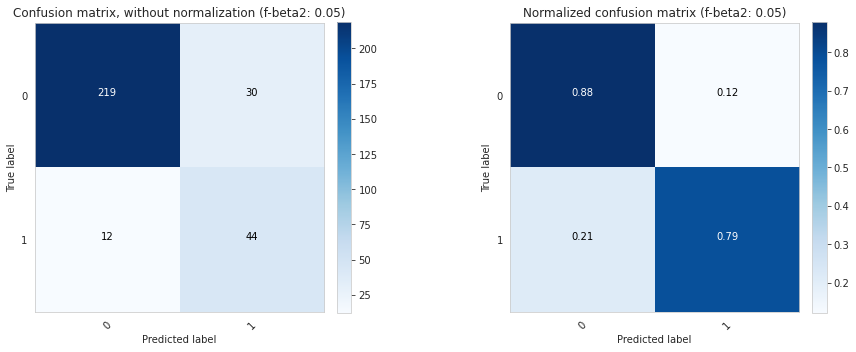



ROC Curve:


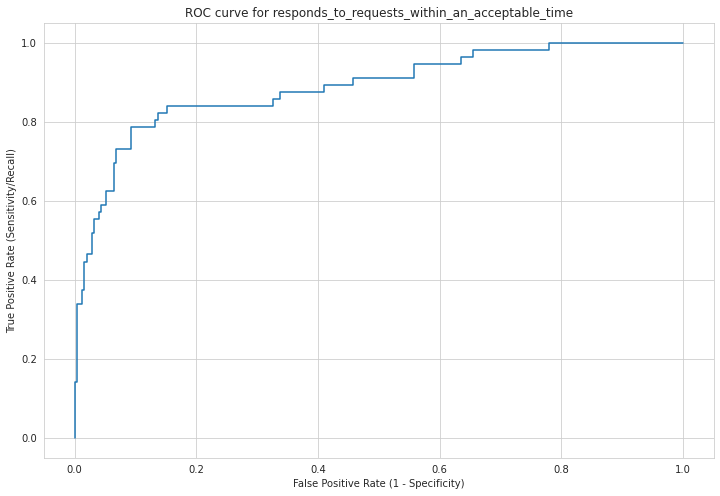

Predicted Probability Distribution:


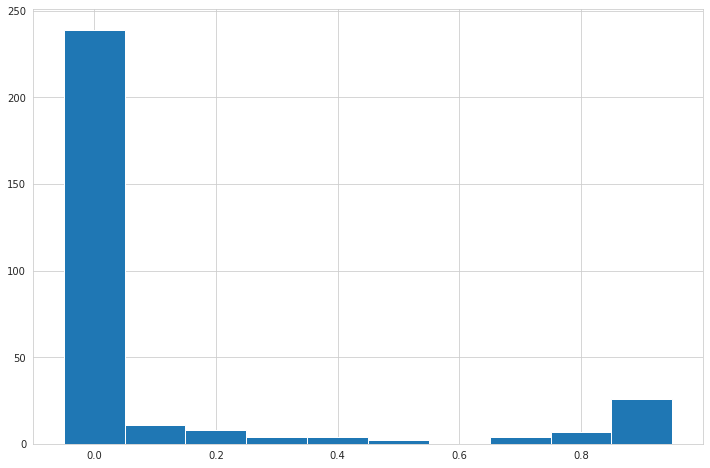



----------------------------------------------------------------------------------------------------


UNDERSTANDS_MY_NEEDS_AND_REQUIREMENTS

Null Accuracy:	0.980327868852459
AUC Score:	0.6794871794871795

		f-beta05(0.44)		f-beta1(0.15)		f-beta2(0.05)
Accuracy:	0.980327868852459	0.9737704918032787	0.9442622950819672	
Cohen's Kappa:	0.0	-0.009933774834437248	0.1670682730923695	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9803              1.0                 0.9901              299                 
1                   0.0                 0.0                 0.0                 6                   
avg/total           0.4902              0.5                 0.495               305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9802              0.9933              0.9867   

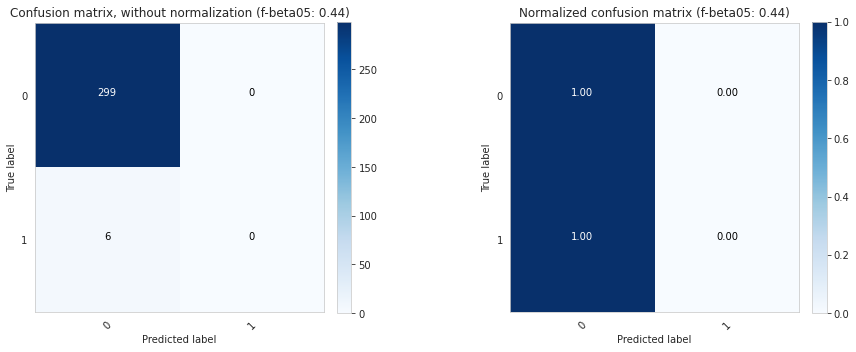

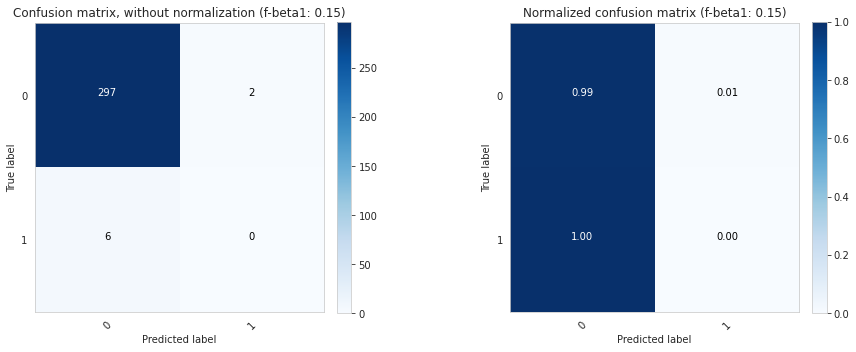

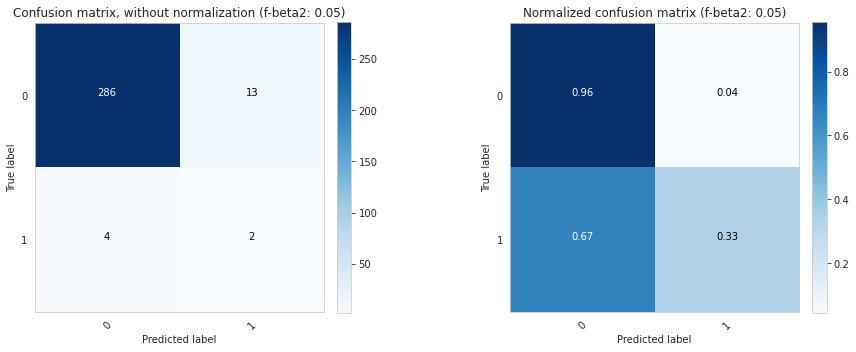



ROC Curve:


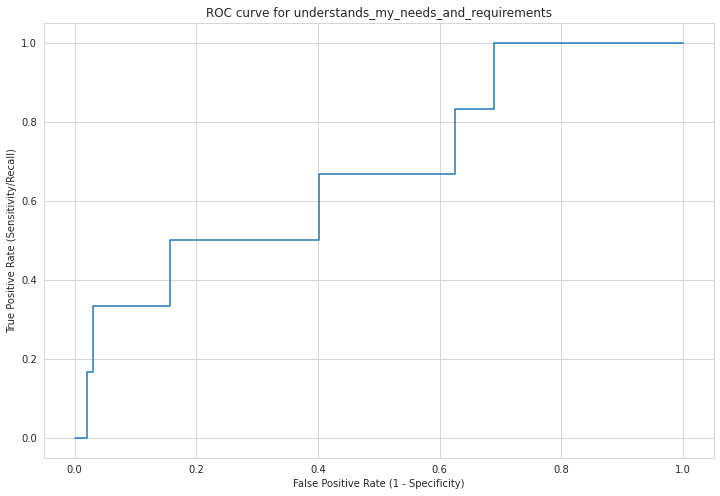

Predicted Probability Distribution:


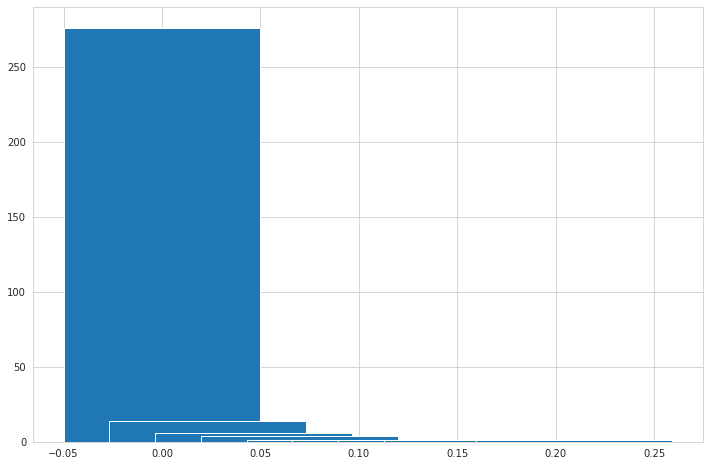



----------------------------------------------------------------------------------------------------




In [146]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Ensemble forwards and backwards passes

In [ ]:
try:
    learn_fwd.purge(); learn = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

bsz = 80
m_suf = '_multilabel'

dls = torch.load(STANDARD_THEME_CSS_PATH/f'data_cls_standard_themes_css.pkl')

learn_fwd = load_learner(fname=STANDARD_THEME_CSS_PATH/f'fwd_export_clas{m_suf}.pkl')
learn_fwd.dls = dls
learn_bwd = load_learner(fname=STANDARD_THEME_CSS_PATH/f'bwd_export_clas{m_suf}.pkl')
learn_bwd.dls = dls

In [ ]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(with_loss=True, reorder=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(with_loss=True, reorder=True)

probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

In [ ]:
loss_fwd.mean(), loss_bwd.mean(), (loss_fwd.mean() + loss_bwd.mean()) / 2

In [ ]:
probs_final = (probs_fwd + probs_bwd) / 2

### Results

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_fwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_fwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_fwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_fwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_bwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_bwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_bwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_bwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_final, lbl_fwd)
threshold_f1 = f1.opt_th(probs_final, lbl_fwd)
threshold_f2 = f2.opt_th(probs_final, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_final, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_final, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_final, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Ensemble Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_final, lbl_fwd, sigmoid=False)}')

In [ ]:
final_valid_loss = (loss_fwd.mean() + probs_bwd.mean()) / 2

### Inference (ad-hoc documents)

In [ ]:
print(STANDARD_THEME_CSS_LABELS)

In [ ]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

for c in test_comments: print(learn_fwd.predict(c, with_input=True))

### Inference (batch ensemble)

In [ ]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 130].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

In [ ]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[:,-1,None] # (e.g. (bs,n_hid,emb_sz) => (bs,1,emb_sz)) 
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [ ]:
def get_theme_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(fname=STANDARD_THEME_CSS_PATH/f'{model_prefix}_export_clas_{m_suf}.pkl', cpu=False)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    tok_inf_df, tok_counts = tokenize_df(inf_df, corpus_cols)
    inf_dl = inf_learn.dls.test_dl(tok_inf_df, rm_type_tfms=None, bs=128)
    if (backwards): inf_dl.tfms.add(Transform(lambda nums: nums.flip(0)))

    # 3. get probs and document vectors
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()
            
            # note: even though there is no targets, each batch is a tuple!
            probs, raw_outputs, outputs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = L(torch.cat(test_probs))
    all_vecs = L(torch.cat(doc_vecs))
    all_concat_vecs = L(torch.cat(concat_doc_vecs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
    all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]
    all_concat_vecs = all_concat_vecs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [ ]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_theme_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_theme_results(backwards=True)

probs_final = (probs_fwd + probs_bwd) / 2

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

Add the probabilities of each label to `inf_df`

In [ ]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

In [ ]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [ ]:
for lbl in STANDARD_THEME_CSS_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [ ]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss

In [ ]:
final_df.head()

In [ ]:
import datetime
final_df.to_csv(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Save document vectors

In [ ]:
%time 

np.save(str(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_fwd.numpy())  
np.save(str(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy'), vecs_fwd.numpy())

np.save(str(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_bwd.numpy())  
np.save(str(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy'), vecs_bwd.numpy())

### Playground

In [ ]:
final_df.iloc[0].threshold_f05, final_df.iloc[0].threshold_f1, final_df.iloc[0].threshold_f2